# MSTAR Testing

encode_pretrained returns data and labels
encode_dataset returns just data


This is taking a while. I am going through this step by step and fixing it. 


## Clean this up

In [ ]:
!pip install -q graphlearning annoy

     |████████████████████████████████| 69 kB 2.3 MB/s 
     |████████████████████████████████| 647 kB 9.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
import graphlearning.active_learning as al
import graphlearning as gl
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import torchvision.models as torch_models
import timeit
import torch
import random
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import torch.nn.functional as F

import utils
import batch_active_learning as bal
import models
from importlib import reload

In [ ]:
reload(bal)
reload(utils)

<module 'utils' from '/content/drive/MyDrive/utils.py'>

# CNNVAE

In [ ]:
#CNN Variational Autoencoder - SarShip 128*128
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()
 
        kernel_size = 3 # (3, 3) kernel
        num_classes = 10
        init_channels = 8 # initial number of filters
        image_channels = 1
        latent_dim = 32 # latent dimension for sampling

        # encoder
        self.enc1 = nn.Conv2d(image_channels, init_channels, kernel_size, padding=1)
        self.enc2 = nn.Conv2d(init_channels, 2*init_channels, kernel_size, padding=1)
        self.enc3 = nn.Conv2d(2*init_channels, 4*init_channels, kernel_size, padding=1)
        self.enc4 = nn.Conv2d(4*init_channels, 64, kernel_size, padding=1)

        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64*16*16, 128)     #Change to 16*16 since that is the dimensions. Note input is flattened
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)

        # decoder 
        self.dec1 = nn.ConvTranspose2d(64, 8*init_channels, kernel_size, output_padding=1, dilation=3)
        self.dec2 = nn.ConvTranspose2d(8*init_channels, 4*init_channels, kernel_size, stride=2, padding=1, output_padding=1)
        self.dec3 = nn.ConvTranspose2d(4*init_channels, 2*init_channels, kernel_size, stride=2, padding=1, output_padding=1) #doubling conv transpose
        self.dec4 = nn.ConvTranspose2d(2*init_channels, image_channels, kernel_size, stride=2, padding=1, output_padding=1)
        self.dec5 = nn.ConvTranspose2d(image_channels, image_channels, kernel_size, stride=2, padding=1, output_padding=1)

        #Dropout
        self.dropout1 = nn.Dropout(0.5)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample

    def encode(self, x):
        x = F.relu(self.enc1(x)) #76  128
        x = F.max_pool2d(x, 2) #38    64
        x = F.leaky_relu(self.enc2(x)) #38  64
        x = F.max_pool2d(x, 2) #19    32
        x = F.leaky_relu(self.enc3(x)) #19  32
        x = F.leaky_relu(self.enc4(x)) #10  32
        x = F.max_pool2d(x, 2) #      16
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        return x

    def decode(self, x):
        x = x.view(-1, 64, 1, 1)
        x = F.leaky_relu(self.dec1(x)) #8
        x = F.leaky_relu(self.dec2(x)) #16
        x = self.dropout1(x)
        x = F.leaky_relu(self.dec3(x))  #32
        x = F.leaky_relu(self.dec4(x))  #64
        x = torch.sigmoid(self.dec5(x))  #128

        return x

    def forward(self, x): #76

        #encode
        x = self.encode(x)
        hidden = self.fc1(x) #(64*10*10, 128)
        
        
        
        
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var) #(64, 16)
        z = self.fc2(z) #(64, 64)

        #decode
        reconstruction = self.decode(z)
        
        return reconstruction, mu, log_var
        
        
class CVAE2(nn.Module):
    def __init__(self):
        super(CVAE2, self).__init__()
 
        kernel_size = 3 # (3, 3) kernel
        num_classes = 10
        init_channels = 8 # initial number of filters
        image_channels = 1
        latent_dim = 32 # latent dimension for sampling

        # encoder
        self.enc1 = nn.Conv2d(image_channels, init_channels, kernel_size, padding=1)
        self.enc2 = nn.Conv2d(init_channels, 2*init_channels, kernel_size, padding=1)
        #self.enc3 = nn.Conv2d(2*init_channels, 4*init_channels, kernel_size, padding=1)
        #self.enc4 = nn.Conv2d(4*init_channels, 64, kernel_size, padding=1)

        # fully connected layers for learning representations
        self.fc1 = nn.Linear(16*32*32, 128)     #Change to 16*16 since that is the dimensions. Note input is flattened
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 64)

        # decoder 
        self.dec1 = nn.ConvTranspose2d(64, 2*init_channels, kernel_size, output_padding=1, dilation=3)
        self.dec2 = nn.ConvTranspose2d(2*init_channels, 1*init_channels, kernel_size=5, stride=4, padding=1, output_padding=1) #quadruple conv transpose
        self.dec3 = nn.ConvTranspose2d(1*init_channels, image_channels, kernel_size=5, stride=4, padding=1, output_padding=1) #doubling conv transpose
        #self.dec4 = nn.ConvTranspose2d(2*init_channels, image_channels, kernel_size, stride=2, padding=1, output_padding=1)
        #self.dec5 = nn.ConvTranspose2d(image_channels, image_channels, kernel_size, stride=2, padding=1, output_padding=1)

        #Dropout
        self.dropout1 = nn.Dropout(0.5)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample

    def encode(self, x):
        x = F.relu(self.enc1(x)) #76  128
        x = F.max_pool2d(x, 2) #38    64
        x = F.relu(self.enc2(x)) #38  64
        x = F.max_pool2d(x, 2) #19    32
        #x = F.leaky_relu(self.enc3(x)) #19  32
        #x = F.leaky_relu(self.enc4(x)) #10  32
        #x = F.max_pool2d(x, 2) #      16
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        return x

    def decode(self, x):
        x = x.view(-1, 64, 1, 1)
        x = F.relu(self.dec1(x)) #8
        x = F.relu(self.dec2(x)) #16
        x = self.dropout1(x)
        x = torch.sigmoid(self.dec3(x))  #32
        #x = F.relu(self.dec4(x))  #64
        #x = torch.sigmoid(self.dec5(x))  #128

        return x

    def forward(self, x): #76

        #encode
        x = self.encode(x)
        hidden = self.fc1(x) #(64*10*10, 128)
        
        
        
        
        # get `mu` and `log_var`
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)

        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var) #(64, 16)
        z = self.fc2(z) #(64, 64)

        #decode
        reconstruction = self.decode(z)
        
        return reconstruction, mu, log_var
        
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        w = (32,64) #Number of channels in 1st and 2nd layers
        self.conv1 = nn.Conv2d(1, w[0], 3, 1)       #change first parameter to be a 1 since only one image channel for grayscale
        self.conv2 = nn.Conv2d(w[0], w[1], 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        f = 512  #Number of hidden nodes in fully connected layers
        #self.fc1 = nn.Linear(w[1]*10*10, f)
        self.fc1 = nn.Linear(64*15*15, f)
        self.fc2 = nn.Linear(f, 10)
        self.bn1 = nn.BatchNorm1d(f)

    def forward(self, x): #88  #128
        x = self.conv1(x) #86  #126
        x = F.relu(x)
        x = F.max_pool2d(x, 2) #43  #63  #124
        x = self.conv2(x) #41  #66  @122
        x = F.relu(x)
        x = F.max_pool2d(x, 4)  #10  #15  @120
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.bn1(x)   #batch normalization
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

    #This is useful for extracting features from convolutional part of NN
    def encode(self, x):
        x = self.conv1(x) #86
        x = F.relu(x)
        x = F.max_pool2d(x, 2) #43
        x = self.conv2(x) #41
        x = F.relu(x)
        x = F.max_pool2d(x, 4)  #10
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        return x

# Active Learning

In [ ]:
#Pick one of 'mstar', 'open_sar', 'fusar'
dataset_chosen = 'fusar'

#This uses a CNNVAE to get embeddings
# **I think this actually uses the fully trained and not a CNNVAE
#Currently we always use the VAE for MSTAR since the knn_data is already stored for this

use_fully_trained_features = False
just_transfer              = False
transfer_and_train         = True

assert(use_fully_trained_features + just_transfer + transfer_and_train == 1)

#If you specify this, then it will use a specific trained NN for embeddings
#If none, it will pick the ones deemed optimal from prior testing
#  I recommend using None
transfer_encoding = None

#Determines the number of points in the coreset
#Larger values correspond to smaller coresets
density_radius_param = .5

knn_num = 17

In [ ]:
start = timeit.default_timer()
with torch.no_grad():
  torch.cuda.empty_cache()

if dataset_chosen == 'open_sar':
  #Load labels
  data, labels = utils.load_dataset('open_sar_ship', return_torch = False, concatenate = True)
elif dataset_chosen == 'fusar':
  #Load labels
  data, labels = utils.load_dataset('fusar', return_torch = False, concatenate = True)
elif dataset_chosen == 'mstar':
  hdr, fields, mag, phase = utils.load_MSTAR('data/MSTAR/')
  data = utils.polar_transform(mag, phase)
  labels, target_names = utils.targets_to_labels(hdr)
else:
  assert False, "Chosen dataset could not be loaded. Check for typos"

knn_data = None

#Mimic that we know a percentage of data, and don't know for the rest
#Do transfer learning merely using these
percent_known_data = 0.05
known_data_ind = gl.trainsets.generate(labels, rate=percent_known_data).tolist()
known_data = data[known_data_ind]
known_labels = labels[known_data_ind]

# print(len(known_data))

#Generate the initial set
initial = gl.trainsets.generate(labels, rate=1).tolist()

#Percent of known data to use as training data for transfer learning
training_percent = 0.7
transfer_train_ind = random.sample(range(len(known_data)), round(len(known_data)*training_percent))
transfer_testing_ind = np.array([ind for ind in range(len(known_data)) if ind not in transfer_train_ind]).astype(int)

#Convert to torch for use
known_data = torch.from_numpy(known_data)
known_labels = torch.from_numpy(known_labels)


#print(len(transfer_testing_ind))
training_data = known_data[transfer_train_ind]
training_label = known_labels[transfer_train_ind]
testing_data = known_data[transfer_testing_ind]
testing_label = known_labels[transfer_testing_ind]

print(len(training_data))
print(len(testing_data))

data_info=[training_data, training_label, testing_data, testing_label]
for item in data_info:
  item = item.float()

        
if dataset_chosen == 'open_sar':
    #Load encoded dataset
    if use_fully_trained_features:
        X = utils.encode_dataset('open_sar_ship','/content/drive/MyDrive/OpenSarShip_CNNVAE.pt')
    elif just_transfer:
        X, labels = utils.encode_pretrained('open_sar_ship', 'AlexNet', transformed=True)
    else:
        X = utils.encode_transfer_learning('open_sar_ship', model_type='AlexNet', transfer_batch_size=64, epochs=30, data_info=data_info)
    #Load labels
    _, labels = utils.load_dataset('open_sar_ship', return_torch = False, concatenate = True)
    knn_data = gl.weightmatrix.knnsearch(X, knn_num, method='annoy', similarity='angular')
elif dataset_chosen == 'fusar':
    #Load encoded dataset
    if use_fully_trained_features:
        X = utils.encode_dataset('fusar','/content/drive/MyDrive/Fusar_CNNVAE.pt')
    elif just_transfer:
        X, labels = utils.encode_pretrained('fusar', 'ShuffleNet', normalized=True, transformed=True)
    else:
        X = utils.encode_transfer_learning('fusar', model_type='ShuffleNet', transfer_batch_size=64, epochs=30, data_info=data_info)
    #Load labels
    _, labels = utils.load_dataset('fusar', return_torch = False, concatenate = True)
    knn_data = gl.weightmatrix.knnsearch(X, knn_num, method='annoy', similarity='angular')
elif dataset_chosen == 'mstar':
    knn_constructed = False
    if use_fully_trained_features:
        X = utils.encodeMSTAR('/content/drive/MyDrive/SAR10_CNNVAE.pt', cuda=False)
        # knn_data = gl.weightmatrix.load_knn_data('sar10', metric='cnnvae') #('knn_data/sar10_cnnvae.npz')
        # knn_constructed = True
    elif just_transfer:
        X, labels = utils.encode_pretrained('mstar', 'ResNet', transformed=False, path = '/content/drive/MyDrive/data/MSTAR')
    else:
        X = utils.encode_transfer_learning('mstar', model_type = 'ResNet', transfer_batch_size=64, epochs=30, data_info=data_info, transformed=False)
    
    print("Constructing knn_data")
    if not knn_constructed:
        knn_data = gl.weightmatrix.knnsearch(X, knn_num, method='annoy', similarity='angular')
    
    
else:
    assert False, "Chosen dataset could not be loaded. Check for typos"

print("Constructing Graph Learning Objects")
W = gl.weightmatrix.knn(X, knn_num, kernel = 'gaussian', knn_data=knn_data)
G = gl.graph(W)
end = timeit.default_timer()

print(X.shape)

print("Complete")
print(f"Time taken = {end - start}")

169
72


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6106 Acc: 0.0651
val Loss: 1.6143 Acc: 0.0278

Epoch 1/29
----------
train Loss: 1.6095 Acc: 0.0710
val Loss: 1.6132 Acc: 0.0278

Epoch 2/29
----------
train Loss: 1.6062 Acc: 0.0947
val Loss: 1.6107 Acc: 0.0278

Epoch 3/29
----------
train Loss: 1.6029 Acc: 0.1420
val Loss: 1.6068 Acc: 0.0278

Epoch 4/29
----------
train Loss: 1.5989 Acc: 0.2781
val Loss: 1.6034 Acc: 0.0556

Epoch 5/29
----------
train Loss: 1.5939 Acc: 0.3905
val Loss: 1.5977 Acc: 0.1806

Epoch 6/29
----------
train Loss: 1.5905 Acc: 0.4497
val Loss: 1.5915 Acc: 0.3889

Epoch 7/29
----------
train Loss: 1.5868 Acc: 0.4556
val Loss: 1.5951 Acc: 0.3056

Epoch 8/29
----------
train Loss: 1.5855 Acc: 0.4497
val Loss: 1.5927 Acc: 0.2917

Epoch 9/29
----------
train Loss: 1.5853 Acc: 0.4320
val Loss: 1.5933 Acc: 0.2778

Epoch 10/29
----------
train Loss: 1.5845 Acc: 0.4556
val Loss: 1.5940 Acc: 0.3750

Epoch 11/29
----------
train Loss: 1.5834 Acc: 0.4497
val Loss: 1.5924 Acc: 0.3889

Ep

In [ ]:
#Use the percent radius because it should be more robust across datasets
coreset = bal.coreset_dijkstras(G, rad = .2, DEBUGGING=False, data = X, initial=initial, 
                                density_info = (True, density_radius_param, 1), knn_data=knn_data)
print("Coreset Size = {}\t Percent of data = {}%".format(len(coreset), round(100 * len(coreset) / len(X), 2)))
print("Coreset = ", coreset)
print(labels[coreset])

Coreset Size = 17	 Percent of data = 0.35%
Coreset =  [320, 4817, 1094, 2035, 1001, 3387, 4258, 1793, 185, 696, 2506, 3040, 2435, 4110, 970, 1165, 1112]
[0 1 2 3 4 2 3 4 0 4 0 2 4 2 3 4 4]


In [ ]:
# acq_fun_list = ['uc', 'vopt', 'mc', 'mcvopt']

acq_fun_list = ['uc']
# max_new_samples = 500

if dataset_chosen == 'open_sar':
  if transfer_and_train:
    coreset = coreset + known_data_ind
    max_new_samples = 574
  else:
    max_new_samples = 700

if dataset_chosen == 'fusar':
  if transfer_and_train:
    coreset = coreset + known_data_ind
    max_new_samples = 2816
  else:
    max_new_samples = 3060
batchsize=15

L_time = []
L_num_labels = []
L_acc = []
L_names = []
for acq_fun in acq_fun_list:

  num_iter = int(max_new_samples/batchsize)

  al_mtd = 'local_max'
  print(acq_fun, al_mtd)
  list_data_ind, list_num_labels, list_acc, running_time_lm = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=num_iter, method='Laplace',
                           display=False, use_prior=False, al_mtd=al_mtd, debug=False,
                           acq_fun=acq_fun, knn_data=knn_data, mtd_para=None,
                           savefig=False, savefig_folder='../BAL_figures', batchsize=batchsize,
                           dist_metric='angular', q=1, thresholding=0, randseed=0)
  L_time.append(running_time_lm)
  L_num_labels.append(list_num_labels)
  L_acc.append(list_acc)
  L_names.append(al_mtd)


  # al_mtd = 'random'
  # print(acq_fun, al_mtd)
  # _, list_num_labels, list_acc, running_time_random = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=num_iter, method='Laplace',
  #                          display=False, use_prior=False, al_mtd=al_mtd, debug=False,
  #                          acq_fun=acq_fun, knn_data=knn_data, mtd_para=None,
  #                          savefig=False, savefig_folder='../BAL_figures', batchsize=batchsize,
  #                          dist_metric='angular', q=5, thresholding=0, randseed=0)
  # L_time.append(running_time_random)
  # L_num_labels.append(list_num_labels)
  # L_acc.append(list_acc)
  # L_names.append(al_mtd)

  # al_mtd = 'topn_max'
  # print(acq_fun, al_mtd)
  # _, list_num_labels, list_acc, running_time_topn = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=num_iter, method='Laplace',
  #                          display=False, use_prior=False, al_mtd=al_mtd, debug=False,
  #                          acq_fun=acq_fun, knn_data=knn_data, mtd_para=None,
  #                          savefig=False, savefig_folder='../BAL_figures', batchsize=batchsize,
  #                          dist_metric='angular', q=1, thresholding=0, randseed=0)
  # L_time.append(running_time_topn)
  # L_num_labels.append(list_num_labels)
  # L_acc.append(list_acc)
  # L_names.append(al_mtd)



  # al_mtd = 'acq_sample'
  # print(acq_fun, al_mtd)
  # _, list_num_labels, list_acc, running_time_acq = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=num_iter, method='Laplace',
  #                          display=False, use_prior=False, al_mtd=al_mtd, debug=False,
  #                          acq_fun=acq_fun, knn_data=knn_data, mtd_para=None,
  #                          savefig=False, savefig_folder='../BAL_figures', batchsize=batchsize,
  #                          dist_metric='angular', q=5, thresholding=0, randseed=0)
  # L_time.append(running_time_acq)
  # L_num_labels.append(list_num_labels)
  # L_acc.append(list_acc)
  # L_names.append(al_mtd)


  # al_mtd = 'global_max'
  # print(acq_fun, al_mtd)
  # _, list_num_labels, list_acc, running_time_gm = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=max_new_samples, method='Laplace',
  #                          display=False, use_prior=False, al_mtd=al_mtd, debug=False,
  #                          acq_fun=acq_fun, knn_data=knn_data, mtd_para=None,
  #                          savefig=False, savefig_folder='../BAL_figures', batchsize=batchsize,
  #                          dist_metric='angular', q=5, thresholding=0, randseed=0)
  # L_time.append(running_time_gm)
  # L_num_labels.append(list_num_labels)
  # L_acc.append(list_acc)
  # L_names.append(al_mtd)

  # al_mtd = 'gd_kmeans'
  # print(acq_fun, al_mtd)
  # _, list_num_labels, list_acc, running_time_acq = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=num_iter, method='Laplace',
  #                          display=False, use_prior=False, al_mtd=al_mtd, debug=False,
  #                          acq_fun=acq_fun, knn_data=knn_data, mtd_para=None,
  #                          savefig=False, savefig_folder='../BAL_figures', batchsize=batchsize,
  #                          dist_metric='angular', q=5, thresholding=0, randseed=0)
  # L_time.append(running_time_acq)
  # L_num_labels.append(list_num_labels)
  # L_acc.append(list_acc)
  # L_names.append(al_mtd)

print(L_acc[0][-1])

uc local_max
Running half of the iterations takes 8.409820998000214
Accuracy for half of the iterations is 80.89711417816812
Running all the iterations takes 13.584661629000038
Final accuracy is 91.85722253206916
91.85722253206916


In [ ]:
list_data_ind = list(list_data_ind)
total_data = known_data_ind + list_data_ind
print(len(set(total_data))/len(data))

0.6307660626029654


74.18341708542714


IndexError: ignored

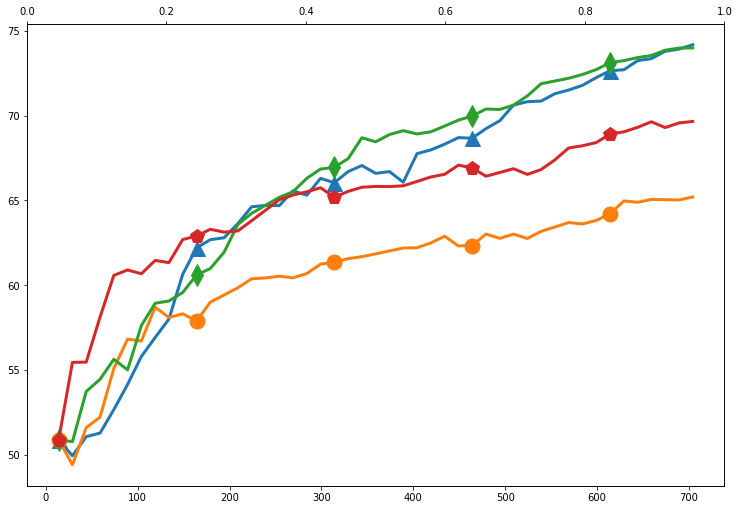

In [ ]:
from google.colab import files

print(L_acc[0][-1])
fontsize=25


fig = plt.figure()
fig.set_size_inches(12.5, 8.5)
ax1 = fig.add_subplot()
ax2 = ax1.twiny()

acq_list = ['uc', 'vopt', 'mc', 'mcvopt']

marker_types = ["^", "o", "d", "p"]

for i in range(len(L_acc)):
    ax1.plot(L_num_labels[i], L_acc[i], label=acq_list[i], linewidth=3, marker=marker_types[i], markevery=10, markersize=15)
    # ax1.plot(L_num_labels[i], L_acc[i], label=acq_list[i], linewidth=3, marker=marker_types[i], markevery=3, markersize=15)

    # ax1.plot(L_num_labels[i], L_acc[i], label=L_names[i], linewidth=3)

#SOTA for Fusar
ax1.plot(L_num_labels[0], 87.16 * np.ones_like(L_num_labels[0]), label='SoTA', linestyle='--')
ax1.plot(L_num_labels[0], 75.36 * np.ones_like(L_num_labels[0]), label='TL', linestyle='--')
#SOTA for Opensar
# ax1.plot(L_num_labels[0], 77.87 * np.ones_like(L_num_labels[0]), label='SoTA', linestyle='--')
# ax1.plot(L_num_labels[0], 76.99 * np.ones_like(L_num_labels[0]), label='TL', linestyle='--')
#SOTA for MSTAR
# ax1.plot(L_num_labels[0], 98.42 * np.ones_like(L_num_labels[0]), label='SoTA', linestyle='--')
ax1.legend(fontsize=fontsize)
ax1.set_xlabel(r"Number of labeled points", fontsize=fontsize)
ax1.set_ylabel("Accuracy (%)", fontsize=fontsize)
ax1.set_ylim((None, 100))

# title_str = 'Coreset size: ' + str(len(coreset)) + '; GL method: Laplace; Al function: local max' + '\n'
title_str = 'Coreset size: ' + str(len(coreset)) + '; GL method: Laplace; Acquisition function: uc' + '\n'
title_str += 'Fusar: Batch Size: ' + str(batchsize) + '; Total num data: ' + str(X.shape[0])

# plt.title(title_str)

# new_tick_locations = np.linspace(0, 0.3, 5) * X.shape[0]
new_tick_locations = np.linspace(0, 0.63, 6) * X.shape[0]


def tick_function(X, n):
    V = X / n
    return ["%d%%" % np.round(100*z) for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations, X.shape[0]), fontsize=fontsize)
ax2.set_xlabel(r"Percentage of Training Data", fontsize=fontsize)

ax1.tick_params(axis='both', labelsize=fontsize)
ax2.tick_params(axis='both', labelsize=fontsize)


plt.savefig('Time Efficiency Fusar.eps', bbox_inches='tight')
# files.download("Time Efficiency Fusar.eps") 
plt.show()


# Test for Average Behavior

In [ ]:
#Pick one of 'mstar', 'open_sar', 'fusar'
dataset_chosen = 'fusar'

#This uses a CNNVAE to get embeddings
# **I think this actually uses the fully trained and not a CNNVAE
#Currently we always use the VAE for MSTAR since the knn_data is already stored for this

use_fully_trained_features = False
just_transfer              = False
transfer_and_train         = True

assert(use_fully_trained_features + just_transfer + transfer_and_train == 1)

#If you specify this, then it will use a specific trained NN for embeddings
#If none, it will pick the ones deemed optimal from prior testing
#  I recommend using None
transfer_encoding = None

#Determines the number of points in the coreset
#Larger values correspond to smaller coresets
density_radius_param = .5

knn_num = 17

In [ ]:
experiment_time = 50

final_acc_list = []
for i in range(experiment_time):
  print("This is experiment " + str(i))

  start = timeit.default_timer()
  with torch.no_grad():
    torch.cuda.empty_cache()

  if dataset_chosen == 'open_sar':
    #Load labels
    data, labels = utils.load_dataset('open_sar_ship', return_torch = False, concatenate = True)
  elif dataset_chosen == 'fusar':
    #Load labels
    data, labels = utils.load_dataset('fusar', return_torch = False, concatenate = True)
  elif dataset_chosen == 'mstar':
    hdr, fields, mag, phase = utils.load_MSTAR('data/MSTAR/')
    data = utils.polar_transform(mag, phase)
    labels, target_names = utils.targets_to_labels(hdr)
  else:
    assert False, "Chosen dataset could not be loaded. Check for typos"

  knn_data = None

  #Mimic that we know a percentage of data, and don't know for the rest
  #Do transfer learning merely using these
  percent_known_data = 0.05
  known_data_ind = gl.trainsets.generate(labels, rate=percent_known_data).tolist()
  known_data = data[known_data_ind]
  known_labels = labels[known_data_ind]

  # print(len(known_data))

  #Generate the initial set
  initial = gl.trainsets.generate(labels, rate=1).tolist()

  #Percent of known data to use as training data for transfer learning
  training_percent = 0.7
  transfer_train_ind = random.sample(range(len(known_data)), round(len(known_data)*training_percent))
  transfer_testing_ind = np.array([ind for ind in range(len(known_data)) if ind not in transfer_train_ind]).astype(int)

  #Convert to torch for use
  known_data = torch.from_numpy(known_data)
  known_labels = torch.from_numpy(known_labels)


  #print(len(transfer_testing_ind))
  training_data = known_data[transfer_train_ind]
  training_label = known_labels[transfer_train_ind]
  testing_data = known_data[transfer_testing_ind]
  testing_label = known_labels[transfer_testing_ind]

  print(len(training_data))
  print(len(testing_data))

  data_info=[training_data, training_label, testing_data, testing_label]
  for item in data_info:
    item = item.float()

          
  if dataset_chosen == 'open_sar':
      #Load encoded dataset
      if use_fully_trained_features:
          X = utils.encode_dataset('open_sar_ship','/content/drive/MyDrive/OpenSarShip_CNNVAE.pt')
      elif just_transfer:
          X, labels = utils.encode_pretrained('open_sar_ship', 'AlexNet', transformed=True)
      else:
          X = utils.encode_transfer_learning('open_sar_ship', model_type='AlexNet', transfer_batch_size=64, epochs=30, data_info=data_info, transformed=False)
      #Load labels
      _, labels = utils.load_dataset('open_sar_ship', return_torch = False, concatenate = True)
      knn_data = gl.weightmatrix.knnsearch(X, knn_num, method='annoy', similarity='angular')
  elif dataset_chosen == 'fusar':
      #Load encoded dataset
      if use_fully_trained_features:
          X = utils.encode_dataset('fusar','/content/drive/MyDrive/Fusar_CNNVAE.pt')
      elif just_transfer:
          X, labels = utils.encode_pretrained('fusar', 'ShuffleNet', normalized=True, transformed=True)
      else:
          X = utils.encode_transfer_learning('fusar', model_type='ShuffleNet', transfer_batch_size=64, epochs=30, data_info=data_info, transformed=False)
      #Load labels
      _, labels = utils.load_dataset('fusar', return_torch = False, concatenate = True)
      knn_data = gl.weightmatrix.knnsearch(X, knn_num, method='annoy', similarity='angular')
  elif dataset_chosen == 'mstar':
      knn_constructed = False
      if use_fully_trained_features:
          X = utils.encodeMSTAR('/content/drive/MyDrive/SAR10_CNNVAE.pt', cuda=False)
          # knn_data = gl.weightmatrix.load_knn_data('sar10', metric='cnnvae') #('knn_data/sar10_cnnvae.npz')
          # knn_constructed = True
      elif just_transfer:
          X, labels = utils.encode_pretrained('mstar', 'ResNet', transformed=False, path = '/content/drive/MyDrive/data/MSTAR')
      else:
          X = utils.encode_transfer_learning('mstar', model_type = 'ResNet', transfer_batch_size=64, epochs=30, data_info=data_info, transformed=False)
      
      print("Constructing knn_data")
      if not knn_constructed:
          knn_data = gl.weightmatrix.knnsearch(X, knn_num, method='annoy', similarity='angular')
      
      
  else:
      assert False, "Chosen dataset could not be loaded. Check for typos"

  print("Constructing Graph Learning Objects")
  W = gl.weightmatrix.knn(X, knn_num, kernel = 'gaussian', knn_data=knn_data)
  G = gl.graph(W)
  end = timeit.default_timer()

  print(X.shape)

  print("Complete")
  print(f"Time taken = {end - start}")



  #Use the percent radius because it should be more robust across datasets
  coreset = bal.coreset_dijkstras(G, rad = .2, DEBUGGING=False, data = X, initial=initial, 
                                  density_info = (True, density_radius_param, 1), knn_data=knn_data)
  print("Coreset Size = {}\t Percent of data = {}%".format(len(coreset), round(100 * len(coreset) / len(X), 2)))
  print("Coreset = ", coreset)
  print(labels[coreset])


  al_mtd = 'local_max'
  acq_fun = 'uc'
  if dataset_chosen == 'open_sar':
    if transfer_and_train:
      coreset = coreset + known_data_ind
      max_new_samples = 574
    else:
      max_new_samples = 700

  if dataset_chosen == 'fusar':
    if transfer_and_train:
      coreset = coreset + known_data_ind
      max_new_samples = 2816
    else:
      max_new_samples = 3060
  batchsize=15

  num_iter = int(max_new_samples/batchsize)
  print(acq_fun, al_mtd)
  list_data_ind, list_num_labels, list_acc, running_time_lm = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=num_iter, method='Laplace',
                           display=False, use_prior=False, al_mtd=al_mtd, debug=False,
                           acq_fun=acq_fun, knn_data=knn_data, mtd_para=None,
                           savefig=False, savefig_folder='../BAL_figures', batchsize=batchsize,
                           dist_metric='angular', q=1, thresholding=0, randseed=0)
  final_acc_list.append(list_acc[-1])
  print(list_acc[-1])
print(final_acc_list)

This is experiment 0
169
72


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X0_5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/29
----------


/content/drive/MyDrive/utils.py:354: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = nn.functional.log_softmax(outputs)


train Loss: 1.6151 Acc: 0.1598
val Loss: 1.6097 Acc: 0.0278

Epoch 1/29
----------
train Loss: 1.6135 Acc: 0.2071
val Loss: 1.6071 Acc: 0.0694

Epoch 2/29
----------
train Loss: 1.6120 Acc: 0.2722
val Loss: 1.6059 Acc: 0.0694

Epoch 3/29
----------
train Loss: 1.6073 Acc: 0.3491
val Loss: 1.6026 Acc: 0.2083

Epoch 4/29
----------
train Loss: 1.6052 Acc: 0.4201
val Loss: 1.5975 Acc: 0.4444

Epoch 5/29
----------
train Loss: 1.6002 Acc: 0.4142
val Loss: 1.5949 Acc: 0.4444

Epoch 6/29
----------
train Loss: 1.5955 Acc: 0.4201
val Loss: 1.5895 Acc: 0.4722

Epoch 7/29
----------
train Loss: 1.5916 Acc: 0.4201
val Loss: 1.5885 Acc: 0.4722

Epoch 8/29
----------
train Loss: 1.5908 Acc: 0.4201
val Loss: 1.5885 Acc: 0.4722

Epoch 9/29
----------
train Loss: 1.5908 Acc: 0.4201
val Loss: 1.5899 Acc: 0.4722

Epoch 10/29
----------
train Loss: 1.5907 Acc: 0.4201
val Loss: 1.5891 Acc: 0.4722

Epoch 11/29
----------
train Loss: 1.5904 Acc: 0.4201
val Loss: 1.5865 Acc: 0.4722

Epoch 12/29
----------
t

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6056 Acc: 0.3964
val Loss: 1.6025 Acc: 0.4028

Epoch 1/29
----------
train Loss: 1.6038 Acc: 0.4024
val Loss: 1.6009 Acc: 0.4306

Epoch 2/29
----------
train Loss: 1.6010 Acc: 0.4260
val Loss: 1.5964 Acc: 0.4444

Epoch 3/29
----------
train Loss: 1.5994 Acc: 0.4320
val Loss: 1.5933 Acc: 0.4444

Epoch 4/29
----------
train Loss: 1.5949 Acc: 0.4320
val Loss: 1.5872 Acc: 0.4444

Epoch 5/29
----------
train Loss: 1.5905 Acc: 0.4320
val Loss: 1.5852 Acc: 0.4444

Epoch 6/29
----------
train Loss: 1.5873 Acc: 0.4320
val Loss: 1.5796 Acc: 0.4444

Epoch 7/29
----------
train Loss: 1.5832 Acc: 0.4320
val Loss: 1.5810 Acc: 0.4444

Epoch 8/29
----------
train Loss: 1.5834 Acc: 0.4260
val Loss: 1.5811 Acc: 0.4444

Epoch 9/29
----------
train Loss: 1.5829 Acc: 0.4320
val Loss: 1.5816 Acc: 0.4306

Epoch 10/29
----------
train Loss: 1.5819 Acc: 0.4320
val Loss: 1.5808 Acc: 0.4444

Epoch 11/29
----------
train Loss: 1.5822 Acc: 0.4320
val Loss: 1.5795 Acc: 0.4444

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6201 Acc: 0.1657
val Loss: 1.6215 Acc: 0.1250

Epoch 1/29
----------
train Loss: 1.6201 Acc: 0.1598
val Loss: 1.6192 Acc: 0.1250

Epoch 2/29
----------
train Loss: 1.6171 Acc: 0.1598
val Loss: 1.6165 Acc: 0.1250

Epoch 3/29
----------
train Loss: 1.6139 Acc: 0.1657
val Loss: 1.6144 Acc: 0.1528

Epoch 4/29
----------
train Loss: 1.6106 Acc: 0.1657
val Loss: 1.6109 Acc: 0.1528

Epoch 5/29
----------
train Loss: 1.6060 Acc: 0.1716
val Loss: 1.6051 Acc: 0.1528

Epoch 6/29
----------
train Loss: 1.6031 Acc: 0.1479
val Loss: 1.6008 Acc: 0.1250

Epoch 7/29
----------
train Loss: 1.5984 Acc: 0.1893
val Loss: 1.6009 Acc: 0.1250

Epoch 8/29
----------
train Loss: 1.5998 Acc: 0.1657
val Loss: 1.5977 Acc: 0.1111

Epoch 9/29
----------
train Loss: 1.5991 Acc: 0.1893
val Loss: 1.5981 Acc: 0.1806

Epoch 10/29
----------
train Loss: 1.5986 Acc: 0.1893
val Loss: 1.5960 Acc: 0.2222

Epoch 11/29
----------
train Loss: 1.5965 Acc: 0.1834
val Loss: 1.5977 Acc: 0.2083

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6084 Acc: 0.3195
val Loss: 1.6105 Acc: 0.2778

Epoch 1/29
----------
train Loss: 1.6054 Acc: 0.3254
val Loss: 1.6097 Acc: 0.2917

Epoch 2/29
----------
train Loss: 1.6032 Acc: 0.3373
val Loss: 1.6076 Acc: 0.3194

Epoch 3/29
----------
train Loss: 1.5996 Acc: 0.3373
val Loss: 1.6043 Acc: 0.3333

Epoch 4/29
----------
train Loss: 1.5986 Acc: 0.3373
val Loss: 1.5984 Acc: 0.3472

Epoch 5/29
----------
train Loss: 1.5934 Acc: 0.3432
val Loss: 1.5942 Acc: 0.3472

Epoch 6/29
----------
train Loss: 1.5870 Acc: 0.3373
val Loss: 1.5900 Acc: 0.3472

Epoch 7/29
----------
train Loss: 1.5852 Acc: 0.3432
val Loss: 1.5891 Acc: 0.3472

Epoch 8/29
----------
train Loss: 1.5850 Acc: 0.3491
val Loss: 1.5877 Acc: 0.3472

Epoch 9/29
----------
train Loss: 1.5848 Acc: 0.3373
val Loss: 1.5864 Acc: 0.3472

Epoch 10/29
----------
train Loss: 1.5835 Acc: 0.3432
val Loss: 1.5848 Acc: 0.3611

Epoch 11/29
----------
train Loss: 1.5835 Acc: 0.3373
val Loss: 1.5835 Acc: 0.3611

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6136 Acc: 0.0710
val Loss: 1.6061 Acc: 0.3750

Epoch 1/29
----------
train Loss: 1.6118 Acc: 0.0888
val Loss: 1.6016 Acc: 0.4583

Epoch 2/29
----------
train Loss: 1.6103 Acc: 0.1243
val Loss: 1.5973 Acc: 0.5139

Epoch 3/29
----------
train Loss: 1.6069 Acc: 0.2130
val Loss: 1.5962 Acc: 0.5139

Epoch 4/29
----------
train Loss: 1.6038 Acc: 0.2781
val Loss: 1.5931 Acc: 0.5278

Epoch 5/29
----------
train Loss: 1.5990 Acc: 0.3728
val Loss: 1.5891 Acc: 0.5417

Epoch 6/29
----------
train Loss: 1.5943 Acc: 0.4024
val Loss: 1.5879 Acc: 0.5139

Epoch 7/29
----------
train Loss: 1.5924 Acc: 0.3728
val Loss: 1.5872 Acc: 0.5000

Epoch 8/29
----------
train Loss: 1.5912 Acc: 0.3846
val Loss: 1.5878 Acc: 0.5278

Epoch 9/29
----------
train Loss: 1.5903 Acc: 0.4438
val Loss: 1.5865 Acc: 0.5139

Epoch 10/29
----------
train Loss: 1.5895 Acc: 0.4260
val Loss: 1.5884 Acc: 0.5139

Epoch 11/29
----------
train Loss: 1.5892 Acc: 0.4201
val Loss: 1.5883 Acc: 0.5139

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6127 Acc: 0.1893
val Loss: 1.6142 Acc: 0.1528

Epoch 1/29
----------
train Loss: 1.6087 Acc: 0.2899
val Loss: 1.6152 Acc: 0.1806

Epoch 2/29
----------
train Loss: 1.6065 Acc: 0.3136
val Loss: 1.6134 Acc: 0.1667

Epoch 3/29
----------
train Loss: 1.6036 Acc: 0.3964
val Loss: 1.6086 Acc: 0.3333

Epoch 4/29
----------
train Loss: 1.5982 Acc: 0.4438
val Loss: 1.6048 Acc: 0.3889

Epoch 5/29
----------
train Loss: 1.5941 Acc: 0.4497
val Loss: 1.5991 Acc: 0.4167

Epoch 6/29
----------
train Loss: 1.5896 Acc: 0.4497
val Loss: 1.5930 Acc: 0.4028

Epoch 7/29
----------
train Loss: 1.5849 Acc: 0.4497
val Loss: 1.5903 Acc: 0.4028

Epoch 8/29
----------
train Loss: 1.5862 Acc: 0.4497
val Loss: 1.5902 Acc: 0.4028

Epoch 9/29
----------
train Loss: 1.5859 Acc: 0.4497
val Loss: 1.5898 Acc: 0.4028

Epoch 10/29
----------
train Loss: 1.5839 Acc: 0.4497
val Loss: 1.5884 Acc: 0.4028

Epoch 11/29
----------
train Loss: 1.5841 Acc: 0.4497
val Loss: 1.5879 Acc: 0.4028

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6113 Acc: 0.1893
val Loss: 1.6073 Acc: 0.1250

Epoch 1/29
----------
train Loss: 1.6103 Acc: 0.1893
val Loss: 1.6069 Acc: 0.1250

Epoch 2/29
----------
train Loss: 1.6080 Acc: 0.2130
val Loss: 1.6050 Acc: 0.1250

Epoch 3/29
----------
train Loss: 1.6055 Acc: 0.2663
val Loss: 1.6016 Acc: 0.1389

Epoch 4/29
----------
train Loss: 1.6021 Acc: 0.2781
val Loss: 1.5988 Acc: 0.1389

Epoch 5/29
----------
train Loss: 1.5989 Acc: 0.3136
val Loss: 1.5946 Acc: 0.1528

Epoch 6/29
----------
train Loss: 1.5936 Acc: 0.3669
val Loss: 1.5918 Acc: 0.1389

Epoch 7/29
----------
train Loss: 1.5908 Acc: 0.3550
val Loss: 1.5921 Acc: 0.1944

Epoch 8/29
----------
train Loss: 1.5909 Acc: 0.3314
val Loss: 1.5916 Acc: 0.1389

Epoch 9/29
----------
train Loss: 1.5903 Acc: 0.3609
val Loss: 1.5902 Acc: 0.2500

Epoch 10/29
----------
train Loss: 1.5891 Acc: 0.3728
val Loss: 1.5895 Acc: 0.2222

Epoch 11/29
----------
train Loss: 1.5899 Acc: 0.3491
val Loss: 1.5880 Acc: 0.3194

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6042 Acc: 0.2663
val Loss: 1.5979 Acc: 0.4722

Epoch 1/29
----------
train Loss: 1.6029 Acc: 0.3609
val Loss: 1.5946 Acc: 0.4722

Epoch 2/29
----------
train Loss: 1.5990 Acc: 0.3669
val Loss: 1.5915 Acc: 0.4722

Epoch 3/29
----------
train Loss: 1.5966 Acc: 0.4142
val Loss: 1.5872 Acc: 0.4722

Epoch 4/29
----------
train Loss: 1.5935 Acc: 0.3964
val Loss: 1.5809 Acc: 0.4722

Epoch 5/29
----------
train Loss: 1.5885 Acc: 0.4201
val Loss: 1.5789 Acc: 0.4722

Epoch 6/29
----------
train Loss: 1.5848 Acc: 0.4083
val Loss: 1.5736 Acc: 0.4722

Epoch 7/29
----------
train Loss: 1.5820 Acc: 0.4024
val Loss: 1.5752 Acc: 0.4861

Epoch 8/29
----------
train Loss: 1.5807 Acc: 0.4201
val Loss: 1.5749 Acc: 0.4722

Epoch 9/29
----------
train Loss: 1.5800 Acc: 0.4142
val Loss: 1.5757 Acc: 0.4444

Epoch 10/29
----------
train Loss: 1.5795 Acc: 0.4024
val Loss: 1.5752 Acc: 0.4861

Epoch 11/29
----------
train Loss: 1.5799 Acc: 0.4024
val Loss: 1.5736 Acc: 0.4444

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6196 Acc: 0.0710
val Loss: 1.6191 Acc: 0.1250

Epoch 1/29
----------
train Loss: 1.6181 Acc: 0.1006
val Loss: 1.6146 Acc: 0.1806

Epoch 2/29
----------
train Loss: 1.6173 Acc: 0.0828
val Loss: 1.6141 Acc: 0.0833

Epoch 3/29
----------
train Loss: 1.6129 Acc: 0.1361
val Loss: 1.6121 Acc: 0.1250

Epoch 4/29
----------
train Loss: 1.6086 Acc: 0.2189
val Loss: 1.6079 Acc: 0.2222

Epoch 5/29
----------
train Loss: 1.6047 Acc: 0.2604
val Loss: 1.6048 Acc: 0.2917

Epoch 6/29
----------
train Loss: 1.6002 Acc: 0.3254
val Loss: 1.6020 Acc: 0.2917

Epoch 7/29
----------
train Loss: 1.5960 Acc: 0.4083
val Loss: 1.5996 Acc: 0.4444

Epoch 8/29
----------
train Loss: 1.5976 Acc: 0.3432
val Loss: 1.6029 Acc: 0.2917

Epoch 9/29
----------
train Loss: 1.5963 Acc: 0.3905
val Loss: 1.6009 Acc: 0.3611

Epoch 10/29
----------
train Loss: 1.5959 Acc: 0.3669
val Loss: 1.6022 Acc: 0.3333

Epoch 11/29
----------
train Loss: 1.5950 Acc: 0.4142
val Loss: 1.5987 Acc: 0.3472

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6130 Acc: 0.1243
val Loss: 1.6126 Acc: 0.1944

Epoch 1/29
----------
train Loss: 1.6113 Acc: 0.1479
val Loss: 1.6121 Acc: 0.1944

Epoch 2/29
----------
train Loss: 1.6103 Acc: 0.1716
val Loss: 1.6081 Acc: 0.2778

Epoch 3/29
----------
train Loss: 1.6061 Acc: 0.1657
val Loss: 1.6058 Acc: 0.2639

Epoch 4/29
----------
train Loss: 1.6009 Acc: 0.2663
val Loss: 1.6026 Acc: 0.2639

Epoch 5/29
----------
train Loss: 1.5990 Acc: 0.2130
val Loss: 1.5971 Acc: 0.3056

Epoch 6/29
----------
train Loss: 1.5937 Acc: 0.2959
val Loss: 1.5934 Acc: 0.3056

Epoch 7/29
----------
train Loss: 1.5907 Acc: 0.3609
val Loss: 1.5941 Acc: 0.3333

Epoch 8/29
----------
train Loss: 1.5900 Acc: 0.3609
val Loss: 1.5931 Acc: 0.2917

Epoch 9/29
----------
train Loss: 1.5903 Acc: 0.3905
val Loss: 1.5921 Acc: 0.2500

Epoch 10/29
----------
train Loss: 1.5891 Acc: 0.3728
val Loss: 1.5927 Acc: 0.2778

Epoch 11/29
----------
train Loss: 1.5892 Acc: 0.3550
val Loss: 1.5916 Acc: 0.2778

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6011 Acc: 0.1420
val Loss: 1.6000 Acc: 0.2361

Epoch 1/29
----------
train Loss: 1.5995 Acc: 0.1420
val Loss: 1.5987 Acc: 0.2917

Epoch 2/29
----------
train Loss: 1.5973 Acc: 0.2722
val Loss: 1.5950 Acc: 0.3472

Epoch 3/29
----------
train Loss: 1.5933 Acc: 0.3018
val Loss: 1.5908 Acc: 0.4306

Epoch 4/29
----------
train Loss: 1.5906 Acc: 0.3609
val Loss: 1.5859 Acc: 0.4583

Epoch 5/29
----------
train Loss: 1.5866 Acc: 0.4201
val Loss: 1.5828 Acc: 0.4583

Epoch 6/29
----------
train Loss: 1.5818 Acc: 0.3964
val Loss: 1.5780 Acc: 0.4722

Epoch 7/29
----------
train Loss: 1.5795 Acc: 0.4379
val Loss: 1.5765 Acc: 0.4583

Epoch 8/29
----------
train Loss: 1.5781 Acc: 0.4024
val Loss: 1.5776 Acc: 0.4722

Epoch 9/29
----------
train Loss: 1.5778 Acc: 0.4320
val Loss: 1.5756 Acc: 0.4583

Epoch 10/29
----------
train Loss: 1.5777 Acc: 0.4260
val Loss: 1.5756 Acc: 0.4167

Epoch 11/29
----------
train Loss: 1.5751 Acc: 0.4438
val Loss: 1.5762 Acc: 0.4306

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6007 Acc: 0.3964
val Loss: 1.6049 Acc: 0.4306

Epoch 1/29
----------
train Loss: 1.5980 Acc: 0.4260
val Loss: 1.6026 Acc: 0.4861

Epoch 2/29
----------
train Loss: 1.5961 Acc: 0.4024
val Loss: 1.6012 Acc: 0.4306

Epoch 3/29
----------
train Loss: 1.5937 Acc: 0.4201
val Loss: 1.5948 Acc: 0.3889

Epoch 4/29
----------
train Loss: 1.5895 Acc: 0.4497
val Loss: 1.5886 Acc: 0.4861

Epoch 5/29
----------
train Loss: 1.5861 Acc: 0.4320
val Loss: 1.5844 Acc: 0.4583

Epoch 6/29
----------
train Loss: 1.5830 Acc: 0.4142
val Loss: 1.5776 Acc: 0.5000

Epoch 7/29
----------
train Loss: 1.5808 Acc: 0.4379
val Loss: 1.5748 Acc: 0.5139

Epoch 8/29
----------
train Loss: 1.5794 Acc: 0.3964
val Loss: 1.5744 Acc: 0.5278

Epoch 9/29
----------
train Loss: 1.5791 Acc: 0.3905
val Loss: 1.5739 Acc: 0.5139

Epoch 10/29
----------
train Loss: 1.5789 Acc: 0.3728
val Loss: 1.5718 Acc: 0.5139

Epoch 11/29
----------
train Loss: 1.5781 Acc: 0.3964
val Loss: 1.5712 Acc: 0.5000

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.5969 Acc: 0.4142
val Loss: 1.5998 Acc: 0.3889

Epoch 1/29
----------
train Loss: 1.5951 Acc: 0.4497
val Loss: 1.5992 Acc: 0.4028

Epoch 2/29
----------
train Loss: 1.5924 Acc: 0.4497
val Loss: 1.5957 Acc: 0.4028

Epoch 3/29
----------
train Loss: 1.5892 Acc: 0.4497
val Loss: 1.5917 Acc: 0.4028

Epoch 4/29
----------
train Loss: 1.5860 Acc: 0.4497
val Loss: 1.5878 Acc: 0.4028

Epoch 5/29
----------
train Loss: 1.5815 Acc: 0.4497
val Loss: 1.5828 Acc: 0.4028

Epoch 6/29
----------
train Loss: 1.5765 Acc: 0.4497
val Loss: 1.5772 Acc: 0.4028

Epoch 7/29
----------
train Loss: 1.5736 Acc: 0.4497
val Loss: 1.5776 Acc: 0.4028

Epoch 8/29
----------
train Loss: 1.5720 Acc: 0.4497
val Loss: 1.5776 Acc: 0.4028

Epoch 9/29
----------
train Loss: 1.5722 Acc: 0.4497
val Loss: 1.5762 Acc: 0.4028

Epoch 10/29
----------
train Loss: 1.5707 Acc: 0.4497
val Loss: 1.5745 Acc: 0.4028

Epoch 11/29
----------
train Loss: 1.5715 Acc: 0.4497
val Loss: 1.5740 Acc: 0.4028

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.5994 Acc: 0.2959
val Loss: 1.5970 Acc: 0.3472

Epoch 1/29
----------
train Loss: 1.5978 Acc: 0.3254
val Loss: 1.5946 Acc: 0.3472

Epoch 2/29
----------
train Loss: 1.5950 Acc: 0.3018
val Loss: 1.5920 Acc: 0.3472

Epoch 3/29
----------
train Loss: 1.5935 Acc: 0.3254
val Loss: 1.5861 Acc: 0.3611

Epoch 4/29
----------
train Loss: 1.5900 Acc: 0.3136
val Loss: 1.5839 Acc: 0.3750

Epoch 5/29
----------
train Loss: 1.5852 Acc: 0.3609
val Loss: 1.5776 Acc: 0.3750

Epoch 6/29
----------
train Loss: 1.5825 Acc: 0.3550
val Loss: 1.5749 Acc: 0.4028

Epoch 7/29
----------
train Loss: 1.5773 Acc: 0.3846
val Loss: 1.5730 Acc: 0.3889

Epoch 8/29
----------
train Loss: 1.5782 Acc: 0.3728
val Loss: 1.5724 Acc: 0.3611

Epoch 9/29
----------
train Loss: 1.5774 Acc: 0.3609
val Loss: 1.5709 Acc: 0.3889

Epoch 10/29
----------
train Loss: 1.5770 Acc: 0.3846
val Loss: 1.5709 Acc: 0.4167

Epoch 11/29
----------
train Loss: 1.5764 Acc: 0.4083
val Loss: 1.5697 Acc: 0.3472

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6075 Acc: 0.3314
val Loss: 1.6082 Acc: 0.2778

Epoch 1/29
----------
train Loss: 1.6056 Acc: 0.3373
val Loss: 1.6066 Acc: 0.2778

Epoch 2/29
----------
train Loss: 1.6038 Acc: 0.3550
val Loss: 1.6041 Acc: 0.2778

Epoch 3/29
----------
train Loss: 1.6002 Acc: 0.3491
val Loss: 1.6001 Acc: 0.2778

Epoch 4/29
----------
train Loss: 1.5958 Acc: 0.3728
val Loss: 1.5955 Acc: 0.2778

Epoch 5/29
----------
train Loss: 1.5918 Acc: 0.3669
val Loss: 1.5928 Acc: 0.2778

Epoch 6/29
----------
train Loss: 1.5879 Acc: 0.3669
val Loss: 1.5878 Acc: 0.2917

Epoch 7/29
----------
train Loss: 1.5843 Acc: 0.3669
val Loss: 1.5862 Acc: 0.2778

Epoch 8/29
----------
train Loss: 1.5824 Acc: 0.3669
val Loss: 1.5867 Acc: 0.2778

Epoch 9/29
----------
train Loss: 1.5827 Acc: 0.3728
val Loss: 1.5857 Acc: 0.2778

Epoch 10/29
----------
train Loss: 1.5826 Acc: 0.3728
val Loss: 1.5835 Acc: 0.3056

Epoch 11/29
----------
train Loss: 1.5817 Acc: 0.3609
val Loss: 1.5851 Acc: 0.2778

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6244 Acc: 0.1479
val Loss: 1.6262 Acc: 0.1806

Epoch 1/29
----------
train Loss: 1.6219 Acc: 0.1538
val Loss: 1.6236 Acc: 0.1806

Epoch 2/29
----------
train Loss: 1.6204 Acc: 0.1598
val Loss: 1.6194 Acc: 0.1806

Epoch 3/29
----------
train Loss: 1.6166 Acc: 0.1538
val Loss: 1.6150 Acc: 0.1944

Epoch 4/29
----------
train Loss: 1.6135 Acc: 0.1538
val Loss: 1.6090 Acc: 0.1944

Epoch 5/29
----------
train Loss: 1.6086 Acc: 0.1598
val Loss: 1.6046 Acc: 0.2222

Epoch 6/29
----------
train Loss: 1.6051 Acc: 0.1538
val Loss: 1.5981 Acc: 0.1667

Epoch 7/29
----------
train Loss: 1.6017 Acc: 0.1834
val Loss: 1.5964 Acc: 0.1944

Epoch 8/29
----------
train Loss: 1.6017 Acc: 0.1775
val Loss: 1.5965 Acc: 0.1944

Epoch 9/29
----------
train Loss: 1.6017 Acc: 0.1538
val Loss: 1.5976 Acc: 0.1944

Epoch 10/29
----------
train Loss: 1.5999 Acc: 0.2189
val Loss: 1.5946 Acc: 0.2639

Epoch 11/29
----------
train Loss: 1.5999 Acc: 0.2130
val Loss: 1.5943 Acc: 0.2361

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6082 Acc: 0.1834
val Loss: 1.6077 Acc: 0.2083

Epoch 1/29
----------
train Loss: 1.6081 Acc: 0.2367
val Loss: 1.6066 Acc: 0.2083

Epoch 2/29
----------
train Loss: 1.6046 Acc: 0.3195
val Loss: 1.6043 Acc: 0.4028

Epoch 3/29
----------
train Loss: 1.6016 Acc: 0.4379
val Loss: 1.6032 Acc: 0.3889

Epoch 4/29
----------
train Loss: 1.5969 Acc: 0.4201
val Loss: 1.5992 Acc: 0.3750

Epoch 5/29
----------
train Loss: 1.5928 Acc: 0.4497
val Loss: 1.5946 Acc: 0.3194

Epoch 6/29
----------
train Loss: 1.5880 Acc: 0.4201
val Loss: 1.5894 Acc: 0.3889

Epoch 7/29
----------
train Loss: 1.5833 Acc: 0.4793
val Loss: 1.5885 Acc: 0.4306

Epoch 8/29
----------
train Loss: 1.5845 Acc: 0.4438
val Loss: 1.5883 Acc: 0.4028

Epoch 9/29
----------
train Loss: 1.5831 Acc: 0.4793
val Loss: 1.5839 Acc: 0.4444

Epoch 10/29
----------
train Loss: 1.5814 Acc: 0.4970
val Loss: 1.5864 Acc: 0.3889

Epoch 11/29
----------
train Loss: 1.5817 Acc: 0.4970
val Loss: 1.5838 Acc: 0.4722

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6001 Acc: 0.4260
val Loss: 1.6019 Acc: 0.4306

Epoch 1/29
----------
train Loss: 1.5980 Acc: 0.4024
val Loss: 1.5999 Acc: 0.4444

Epoch 2/29
----------
train Loss: 1.5969 Acc: 0.4379
val Loss: 1.5942 Acc: 0.4306

Epoch 3/29
----------
train Loss: 1.5936 Acc: 0.4260
val Loss: 1.5915 Acc: 0.4444

Epoch 4/29
----------
train Loss: 1.5893 Acc: 0.4201
val Loss: 1.5847 Acc: 0.4444

Epoch 5/29
----------
train Loss: 1.5856 Acc: 0.4497
val Loss: 1.5794 Acc: 0.4444

Epoch 6/29
----------
train Loss: 1.5837 Acc: 0.4260
val Loss: 1.5744 Acc: 0.4444

Epoch 7/29
----------
train Loss: 1.5799 Acc: 0.4260
val Loss: 1.5736 Acc: 0.4444

Epoch 8/29
----------
train Loss: 1.5781 Acc: 0.4320
val Loss: 1.5700 Acc: 0.4444

Epoch 9/29
----------
train Loss: 1.5783 Acc: 0.4260
val Loss: 1.5701 Acc: 0.4444

Epoch 10/29
----------
train Loss: 1.5778 Acc: 0.4260
val Loss: 1.5705 Acc: 0.4444

Epoch 11/29
----------
train Loss: 1.5780 Acc: 0.4320
val Loss: 1.5698 Acc: 0.4444

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.5913 Acc: 0.3550
val Loss: 1.5890 Acc: 0.3472

Epoch 1/29
----------
train Loss: 1.5895 Acc: 0.3550
val Loss: 1.5863 Acc: 0.4028

Epoch 2/29
----------
train Loss: 1.5874 Acc: 0.3669
val Loss: 1.5830 Acc: 0.4028

Epoch 3/29
----------
train Loss: 1.5847 Acc: 0.3314
val Loss: 1.5780 Acc: 0.3611

Epoch 4/29
----------
train Loss: 1.5803 Acc: 0.3609
val Loss: 1.5753 Acc: 0.3194

Epoch 5/29
----------
train Loss: 1.5764 Acc: 0.3728
val Loss: 1.5704 Acc: 0.3611

Epoch 6/29
----------
train Loss: 1.5733 Acc: 0.3491
val Loss: 1.5655 Acc: 0.4306

Epoch 7/29
----------
train Loss: 1.5678 Acc: 0.3964
val Loss: 1.5625 Acc: 0.4583

Epoch 8/29
----------
train Loss: 1.5684 Acc: 0.3846
val Loss: 1.5635 Acc: 0.3333

Epoch 9/29
----------
train Loss: 1.5683 Acc: 0.3964
val Loss: 1.5631 Acc: 0.3333

Epoch 10/29
----------
train Loss: 1.5689 Acc: 0.3728
val Loss: 1.5641 Acc: 0.3750

Epoch 11/29
----------
train Loss: 1.5677 Acc: 0.3787
val Loss: 1.5644 Acc: 0.3333

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6074 Acc: 0.3432
val Loss: 1.6051 Acc: 0.2639

Epoch 1/29
----------
train Loss: 1.6063 Acc: 0.3491
val Loss: 1.6027 Acc: 0.3056

Epoch 2/29
----------
train Loss: 1.6042 Acc: 0.4142
val Loss: 1.5996 Acc: 0.4306

Epoch 3/29
----------
train Loss: 1.6007 Acc: 0.4260
val Loss: 1.5957 Acc: 0.4306

Epoch 4/29
----------
train Loss: 1.5969 Acc: 0.4320
val Loss: 1.5931 Acc: 0.4444

Epoch 5/29
----------
train Loss: 1.5924 Acc: 0.4320
val Loss: 1.5899 Acc: 0.4444

Epoch 6/29
----------
train Loss: 1.5869 Acc: 0.4320
val Loss: 1.5857 Acc: 0.4444

Epoch 7/29
----------
train Loss: 1.5838 Acc: 0.4320
val Loss: 1.5856 Acc: 0.4444

Epoch 8/29
----------
train Loss: 1.5824 Acc: 0.4320
val Loss: 1.5849 Acc: 0.4444

Epoch 9/29
----------
train Loss: 1.5831 Acc: 0.4320
val Loss: 1.5855 Acc: 0.4444

Epoch 10/29
----------
train Loss: 1.5815 Acc: 0.4260
val Loss: 1.5857 Acc: 0.4444

Epoch 11/29
----------
train Loss: 1.5824 Acc: 0.4320
val Loss: 1.5824 Acc: 0.4444

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.5982 Acc: 0.3077
val Loss: 1.5942 Acc: 0.3611

Epoch 1/29
----------
train Loss: 1.5964 Acc: 0.3373
val Loss: 1.5930 Acc: 0.3750

Epoch 2/29
----------
train Loss: 1.5951 Acc: 0.3550
val Loss: 1.5920 Acc: 0.3056

Epoch 3/29
----------
train Loss: 1.5914 Acc: 0.3669
val Loss: 1.5883 Acc: 0.3472

Epoch 4/29
----------
train Loss: 1.5888 Acc: 0.3964
val Loss: 1.5848 Acc: 0.4167

Epoch 5/29
----------
train Loss: 1.5850 Acc: 0.3550
val Loss: 1.5817 Acc: 0.4306

Epoch 6/29
----------
train Loss: 1.5797 Acc: 0.3728
val Loss: 1.5780 Acc: 0.3472

Epoch 7/29
----------
train Loss: 1.5768 Acc: 0.4142
val Loss: 1.5780 Acc: 0.4028

Epoch 8/29
----------
train Loss: 1.5748 Acc: 0.4083
val Loss: 1.5768 Acc: 0.4722

Epoch 9/29
----------
train Loss: 1.5758 Acc: 0.3787
val Loss: 1.5782 Acc: 0.3333

Epoch 10/29
----------
train Loss: 1.5743 Acc: 0.4201
val Loss: 1.5792 Acc: 0.3889

Epoch 11/29
----------
train Loss: 1.5740 Acc: 0.3846
val Loss: 1.5770 Acc: 0.3889

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6206 Acc: 0.0296
val Loss: 1.6128 Acc: 0.0278

Epoch 1/29
----------
train Loss: 1.6189 Acc: 0.0296
val Loss: 1.6102 Acc: 0.0278

Epoch 2/29
----------
train Loss: 1.6175 Acc: 0.0710
val Loss: 1.6077 Acc: 0.0833

Epoch 3/29
----------
train Loss: 1.6137 Acc: 0.1065
val Loss: 1.6041 Acc: 0.0694

Epoch 4/29
----------
train Loss: 1.6102 Acc: 0.1893
val Loss: 1.6014 Acc: 0.1667

Epoch 5/29
----------
train Loss: 1.6059 Acc: 0.3077
val Loss: 1.5975 Acc: 0.2222

Epoch 6/29
----------
train Loss: 1.6010 Acc: 0.3846
val Loss: 1.5924 Acc: 0.3889

Epoch 7/29
----------
train Loss: 1.5996 Acc: 0.3787
val Loss: 1.5922 Acc: 0.3889

Epoch 8/29
----------
train Loss: 1.5981 Acc: 0.3787
val Loss: 1.5937 Acc: 0.3194

Epoch 9/29
----------
train Loss: 1.5981 Acc: 0.3669
val Loss: 1.5927 Acc: 0.4028

Epoch 10/29
----------
train Loss: 1.5981 Acc: 0.3609
val Loss: 1.5921 Acc: 0.3333

Epoch 11/29
----------
train Loss: 1.5974 Acc: 0.3669
val Loss: 1.5911 Acc: 0.4444

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6167 Acc: 0.1124
val Loss: 1.6123 Acc: 0.1111

Epoch 1/29
----------
train Loss: 1.6130 Acc: 0.1893
val Loss: 1.6108 Acc: 0.1528

Epoch 2/29
----------
train Loss: 1.6112 Acc: 0.2071
val Loss: 1.6073 Acc: 0.2500

Epoch 3/29
----------
train Loss: 1.6083 Acc: 0.2781
val Loss: 1.6033 Acc: 0.2778

Epoch 4/29
----------
train Loss: 1.6038 Acc: 0.3609
val Loss: 1.5998 Acc: 0.4306

Epoch 5/29
----------
train Loss: 1.6000 Acc: 0.3432
val Loss: 1.5946 Acc: 0.3611

Epoch 6/29
----------
train Loss: 1.5953 Acc: 0.3373
val Loss: 1.5906 Acc: 0.3472

Epoch 7/29
----------
train Loss: 1.5908 Acc: 0.3669
val Loss: 1.5900 Acc: 0.3611

Epoch 8/29
----------
train Loss: 1.5917 Acc: 0.3491
val Loss: 1.5905 Acc: 0.4028

Epoch 9/29
----------
train Loss: 1.5913 Acc: 0.3550
val Loss: 1.5919 Acc: 0.3889

Epoch 10/29
----------
train Loss: 1.5906 Acc: 0.3669
val Loss: 1.5895 Acc: 0.4444

Epoch 11/29
----------
train Loss: 1.5913 Acc: 0.3669
val Loss: 1.5899 Acc: 0.4167

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6172 Acc: 0.0473
val Loss: 1.6123 Acc: 0.0000

Epoch 1/29
----------
train Loss: 1.6148 Acc: 0.0533
val Loss: 1.6125 Acc: 0.0139

Epoch 2/29
----------
train Loss: 1.6127 Acc: 0.0888
val Loss: 1.6089 Acc: 0.0694

Epoch 3/29
----------
train Loss: 1.6092 Acc: 0.1538
val Loss: 1.6055 Acc: 0.0972

Epoch 4/29
----------
train Loss: 1.6059 Acc: 0.2485
val Loss: 1.6018 Acc: 0.3333

Epoch 5/29
----------
train Loss: 1.6002 Acc: 0.3609
val Loss: 1.5973 Acc: 0.4167

Epoch 6/29
----------
train Loss: 1.5951 Acc: 0.4260
val Loss: 1.5917 Acc: 0.5000

Epoch 7/29
----------
train Loss: 1.5920 Acc: 0.3964
val Loss: 1.5940 Acc: 0.4444

Epoch 8/29
----------
train Loss: 1.5932 Acc: 0.3491
val Loss: 1.5945 Acc: 0.3750

Epoch 9/29
----------
train Loss: 1.5905 Acc: 0.4438
val Loss: 1.5924 Acc: 0.4861

Epoch 10/29
----------
train Loss: 1.5913 Acc: 0.3728
val Loss: 1.5910 Acc: 0.4306

Epoch 11/29
----------
train Loss: 1.5893 Acc: 0.4379
val Loss: 1.5914 Acc: 0.4444

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6035 Acc: 0.2189
val Loss: 1.5979 Acc: 0.3611

Epoch 1/29
----------
train Loss: 1.6016 Acc: 0.2130
val Loss: 1.5967 Acc: 0.2778

Epoch 2/29
----------
train Loss: 1.5987 Acc: 0.2663
val Loss: 1.5949 Acc: 0.3611

Epoch 3/29
----------
train Loss: 1.5964 Acc: 0.2249
val Loss: 1.5904 Acc: 0.3333

Epoch 4/29
----------
train Loss: 1.5913 Acc: 0.3077
val Loss: 1.5854 Acc: 0.4028

Epoch 5/29
----------
train Loss: 1.5877 Acc: 0.2781
val Loss: 1.5813 Acc: 0.3472

Epoch 6/29
----------
train Loss: 1.5833 Acc: 0.3077
val Loss: 1.5774 Acc: 0.3056

Epoch 7/29
----------
train Loss: 1.5806 Acc: 0.3136
val Loss: 1.5745 Acc: 0.3750

Epoch 8/29
----------
train Loss: 1.5791 Acc: 0.3550
val Loss: 1.5750 Acc: 0.3611

Epoch 9/29
----------
train Loss: 1.5788 Acc: 0.3373
val Loss: 1.5748 Acc: 0.3611

Epoch 10/29
----------
train Loss: 1.5775 Acc: 0.4024
val Loss: 1.5757 Acc: 0.2778

Epoch 11/29
----------
train Loss: 1.5786 Acc: 0.3491
val Loss: 1.5752 Acc: 0.3472

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6204 Acc: 0.0118
val Loss: 1.6182 Acc: 0.0278

Epoch 1/29
----------
train Loss: 1.6196 Acc: 0.0118
val Loss: 1.6182 Acc: 0.0139

Epoch 2/29
----------
train Loss: 1.6153 Acc: 0.0296
val Loss: 1.6170 Acc: 0.0417

Epoch 3/29
----------
train Loss: 1.6120 Acc: 0.0888
val Loss: 1.6129 Acc: 0.0417

Epoch 4/29
----------
train Loss: 1.6067 Acc: 0.1657
val Loss: 1.6098 Acc: 0.1389

Epoch 5/29
----------
train Loss: 1.6008 Acc: 0.3905
val Loss: 1.6043 Acc: 0.2917

Epoch 6/29
----------
train Loss: 1.5983 Acc: 0.4201
val Loss: 1.5980 Acc: 0.3750

Epoch 7/29
----------
train Loss: 1.5947 Acc: 0.4556
val Loss: 1.5986 Acc: 0.3611

Epoch 8/29
----------
train Loss: 1.5925 Acc: 0.4675
val Loss: 1.5970 Acc: 0.3750

Epoch 9/29
----------
train Loss: 1.5911 Acc: 0.4675
val Loss: 1.5966 Acc: 0.3750

Epoch 10/29
----------
train Loss: 1.5926 Acc: 0.4615
val Loss: 1.5962 Acc: 0.3750

Epoch 11/29
----------
train Loss: 1.5904 Acc: 0.4615
val Loss: 1.5950 Acc: 0.3750

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6143 Acc: 0.0533
val Loss: 1.6082 Acc: 0.1111

Epoch 1/29
----------
train Loss: 1.6113 Acc: 0.1006
val Loss: 1.6056 Acc: 0.1250

Epoch 2/29
----------
train Loss: 1.6104 Acc: 0.1006
val Loss: 1.6019 Acc: 0.2361

Epoch 3/29
----------
train Loss: 1.6059 Acc: 0.1657
val Loss: 1.5964 Acc: 0.3194

Epoch 4/29
----------
train Loss: 1.6024 Acc: 0.2781
val Loss: 1.5958 Acc: 0.2778

Epoch 5/29
----------
train Loss: 1.5975 Acc: 0.3609
val Loss: 1.5913 Acc: 0.3056

Epoch 6/29
----------
train Loss: 1.5941 Acc: 0.3787
val Loss: 1.5871 Acc: 0.3611

Epoch 7/29
----------
train Loss: 1.5893 Acc: 0.4260
val Loss: 1.5880 Acc: 0.2361

Epoch 8/29
----------
train Loss: 1.5874 Acc: 0.4142
val Loss: 1.5879 Acc: 0.2222

Epoch 9/29
----------
train Loss: 1.5900 Acc: 0.3964
val Loss: 1.5894 Acc: 0.2361

Epoch 10/29
----------
train Loss: 1.5892 Acc: 0.4201
val Loss: 1.5870 Acc: 0.4028

Epoch 11/29
----------
train Loss: 1.5886 Acc: 0.4024
val Loss: 1.5859 Acc: 0.4306

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6145 Acc: 0.1124
val Loss: 1.6136 Acc: 0.0556

Epoch 1/29
----------
train Loss: 1.6135 Acc: 0.0828
val Loss: 1.6105 Acc: 0.0972

Epoch 2/29
----------
train Loss: 1.6099 Acc: 0.2012
val Loss: 1.6068 Acc: 0.2917

Epoch 3/29
----------
train Loss: 1.6059 Acc: 0.2663
val Loss: 1.6028 Acc: 0.3333

Epoch 4/29
----------
train Loss: 1.6010 Acc: 0.3787
val Loss: 1.6001 Acc: 0.4028

Epoch 5/29
----------
train Loss: 1.5966 Acc: 0.4556
val Loss: 1.5962 Acc: 0.4167

Epoch 6/29
----------
train Loss: 1.5918 Acc: 0.4320
val Loss: 1.5921 Acc: 0.3472

Epoch 7/29
----------
train Loss: 1.5873 Acc: 0.4497
val Loss: 1.5923 Acc: 0.3472

Epoch 8/29
----------
train Loss: 1.5870 Acc: 0.4379
val Loss: 1.5931 Acc: 0.3750

Epoch 9/29
----------
train Loss: 1.5868 Acc: 0.3669
val Loss: 1.5928 Acc: 0.3472

Epoch 10/29
----------
train Loss: 1.5861 Acc: 0.4260
val Loss: 1.5910 Acc: 0.3194

Epoch 11/29
----------
train Loss: 1.5856 Acc: 0.3964
val Loss: 1.5902 Acc: 0.3194

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6202 Acc: 0.0651
val Loss: 1.6230 Acc: 0.0972

Epoch 1/29
----------
train Loss: 1.6189 Acc: 0.0414
val Loss: 1.6233 Acc: 0.0833

Epoch 2/29
----------
train Loss: 1.6159 Acc: 0.1243
val Loss: 1.6184 Acc: 0.1111

Epoch 3/29
----------
train Loss: 1.6145 Acc: 0.1006
val Loss: 1.6175 Acc: 0.1111

Epoch 4/29
----------
train Loss: 1.6100 Acc: 0.1834
val Loss: 1.6122 Acc: 0.0972

Epoch 5/29
----------
train Loss: 1.6053 Acc: 0.2308
val Loss: 1.6075 Acc: 0.1111

Epoch 6/29
----------
train Loss: 1.6017 Acc: 0.2367
val Loss: 1.6015 Acc: 0.1667

Epoch 7/29
----------
train Loss: 1.5980 Acc: 0.3254
val Loss: 1.5991 Acc: 0.2083

Epoch 8/29
----------
train Loss: 1.5983 Acc: 0.2959
val Loss: 1.6009 Acc: 0.2222

Epoch 9/29
----------
train Loss: 1.5973 Acc: 0.3491
val Loss: 1.5982 Acc: 0.1389

Epoch 10/29
----------
train Loss: 1.5976 Acc: 0.3077
val Loss: 1.5949 Acc: 0.2083

Epoch 11/29
----------
train Loss: 1.5969 Acc: 0.3136
val Loss: 1.5964 Acc: 0.2222

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.5900 Acc: 0.4556
val Loss: 1.5967 Acc: 0.4167

Epoch 1/29
----------
train Loss: 1.5879 Acc: 0.4438
val Loss: 1.5958 Acc: 0.4167

Epoch 2/29
----------
train Loss: 1.5854 Acc: 0.4379
val Loss: 1.5944 Acc: 0.4028

Epoch 3/29
----------
train Loss: 1.5840 Acc: 0.4379
val Loss: 1.5912 Acc: 0.4167

Epoch 4/29
----------
train Loss: 1.5779 Acc: 0.4438
val Loss: 1.5875 Acc: 0.4167

Epoch 5/29
----------
train Loss: 1.5742 Acc: 0.4438
val Loss: 1.5824 Acc: 0.4167

Epoch 6/29
----------
train Loss: 1.5708 Acc: 0.4497
val Loss: 1.5778 Acc: 0.4167

Epoch 7/29
----------
train Loss: 1.5666 Acc: 0.4438
val Loss: 1.5780 Acc: 0.4167

Epoch 8/29
----------
train Loss: 1.5660 Acc: 0.4438
val Loss: 1.5741 Acc: 0.4167

Epoch 9/29
----------
train Loss: 1.5656 Acc: 0.4438
val Loss: 1.5724 Acc: 0.4306

Epoch 10/29
----------
train Loss: 1.5659 Acc: 0.4438
val Loss: 1.5721 Acc: 0.4167

Epoch 11/29
----------
train Loss: 1.5648 Acc: 0.4379
val Loss: 1.5717 Acc: 0.4167

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.5993 Acc: 0.3254
val Loss: 1.5923 Acc: 0.5278

Epoch 1/29
----------
train Loss: 1.5988 Acc: 0.3787
val Loss: 1.5902 Acc: 0.5417

Epoch 2/29
----------
train Loss: 1.5985 Acc: 0.3373
val Loss: 1.5872 Acc: 0.5417

Epoch 3/29
----------
train Loss: 1.5965 Acc: 0.3491
val Loss: 1.5844 Acc: 0.5278

Epoch 4/29
----------
train Loss: 1.5920 Acc: 0.3905
val Loss: 1.5772 Acc: 0.5417

Epoch 5/29
----------
train Loss: 1.5890 Acc: 0.3964
val Loss: 1.5733 Acc: 0.5556

Epoch 6/29
----------
train Loss: 1.5826 Acc: 0.3964
val Loss: 1.5680 Acc: 0.5417

Epoch 7/29
----------
train Loss: 1.5826 Acc: 0.3905
val Loss: 1.5664 Acc: 0.5278

Epoch 8/29
----------
train Loss: 1.5816 Acc: 0.3964
val Loss: 1.5666 Acc: 0.5139

Epoch 9/29
----------
train Loss: 1.5802 Acc: 0.3905
val Loss: 1.5671 Acc: 0.5278

Epoch 10/29
----------
train Loss: 1.5793 Acc: 0.3964
val Loss: 1.5688 Acc: 0.5278

Epoch 11/29
----------
train Loss: 1.5806 Acc: 0.3964
val Loss: 1.5672 Acc: 0.5139

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6025 Acc: 0.4201
val Loss: 1.6032 Acc: 0.4306

Epoch 1/29
----------
train Loss: 1.6030 Acc: 0.4201
val Loss: 1.5999 Acc: 0.4444

Epoch 2/29
----------
train Loss: 1.5986 Acc: 0.4260
val Loss: 1.5983 Acc: 0.4583

Epoch 3/29
----------
train Loss: 1.5956 Acc: 0.4260
val Loss: 1.5939 Acc: 0.4583

Epoch 4/29
----------
train Loss: 1.5929 Acc: 0.4260
val Loss: 1.5892 Acc: 0.4583

Epoch 5/29
----------
train Loss: 1.5879 Acc: 0.4260
val Loss: 1.5851 Acc: 0.4583

Epoch 6/29
----------
train Loss: 1.5839 Acc: 0.4260
val Loss: 1.5780 Acc: 0.4583

Epoch 7/29
----------
train Loss: 1.5806 Acc: 0.4260
val Loss: 1.5786 Acc: 0.4583

Epoch 8/29
----------
train Loss: 1.5808 Acc: 0.4260
val Loss: 1.5784 Acc: 0.4583

Epoch 9/29
----------
train Loss: 1.5802 Acc: 0.4260
val Loss: 1.5775 Acc: 0.4583

Epoch 10/29
----------
train Loss: 1.5813 Acc: 0.4260
val Loss: 1.5756 Acc: 0.4583

Epoch 11/29
----------
train Loss: 1.5813 Acc: 0.4260
val Loss: 1.5748 Acc: 0.4583

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6124 Acc: 0.1420
val Loss: 1.6210 Acc: 0.0833

Epoch 1/29
----------
train Loss: 1.6118 Acc: 0.1716
val Loss: 1.6178 Acc: 0.0556

Epoch 2/29
----------
train Loss: 1.6090 Acc: 0.1716
val Loss: 1.6130 Acc: 0.1111

Epoch 3/29
----------
train Loss: 1.6053 Acc: 0.2189
val Loss: 1.6070 Acc: 0.1806

Epoch 4/29
----------
train Loss: 1.6033 Acc: 0.2485
val Loss: 1.6026 Acc: 0.2222

Epoch 5/29
----------
train Loss: 1.5997 Acc: 0.3077
val Loss: 1.5987 Acc: 0.3472

Epoch 6/29
----------
train Loss: 1.5965 Acc: 0.3373
val Loss: 1.5928 Acc: 0.4722

Epoch 7/29
----------
train Loss: 1.5934 Acc: 0.3432
val Loss: 1.5898 Acc: 0.4722

Epoch 8/29
----------
train Loss: 1.5934 Acc: 0.3432
val Loss: 1.5887 Acc: 0.5278

Epoch 9/29
----------
train Loss: 1.5928 Acc: 0.3373
val Loss: 1.5894 Acc: 0.5694

Epoch 10/29
----------
train Loss: 1.5927 Acc: 0.3491
val Loss: 1.5900 Acc: 0.4306

Epoch 11/29
----------
train Loss: 1.5933 Acc: 0.3373
val Loss: 1.5866 Acc: 0.5417

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6088 Acc: 0.0947
val Loss: 1.5944 Acc: 0.4306

Epoch 1/29
----------
train Loss: 1.6063 Acc: 0.1124
val Loss: 1.5899 Acc: 0.4861

Epoch 2/29
----------
train Loss: 1.6054 Acc: 0.1538
val Loss: 1.5850 Acc: 0.4583

Epoch 3/29
----------
train Loss: 1.6033 Acc: 0.2249
val Loss: 1.5833 Acc: 0.4028

Epoch 4/29
----------
train Loss: 1.5994 Acc: 0.2899
val Loss: 1.5771 Acc: 0.4167

Epoch 5/29
----------
train Loss: 1.5950 Acc: 0.3373
val Loss: 1.5744 Acc: 0.4722

Epoch 6/29
----------
train Loss: 1.5920 Acc: 0.3609
val Loss: 1.5742 Acc: 0.4444

Epoch 7/29
----------
train Loss: 1.5882 Acc: 0.3905
val Loss: 1.5739 Acc: 0.5000

Epoch 8/29
----------
train Loss: 1.5889 Acc: 0.3254
val Loss: 1.5745 Acc: 0.5000

Epoch 9/29
----------
train Loss: 1.5894 Acc: 0.3373
val Loss: 1.5734 Acc: 0.4444

Epoch 10/29
----------
train Loss: 1.5885 Acc: 0.3373
val Loss: 1.5775 Acc: 0.3750

Epoch 11/29
----------
train Loss: 1.5873 Acc: 0.4142
val Loss: 1.5778 Acc: 0.3333

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6136 Acc: 0.2071
val Loss: 1.6092 Acc: 0.3611

Epoch 1/29
----------
train Loss: 1.6112 Acc: 0.2722
val Loss: 1.6061 Acc: 0.4028

Epoch 2/29
----------
train Loss: 1.6085 Acc: 0.3432
val Loss: 1.6038 Acc: 0.3889

Epoch 3/29
----------
train Loss: 1.6050 Acc: 0.4142
val Loss: 1.6006 Acc: 0.4028

Epoch 4/29
----------
train Loss: 1.6008 Acc: 0.4556
val Loss: 1.5973 Acc: 0.4028

Epoch 5/29
----------
train Loss: 1.5966 Acc: 0.4497
val Loss: 1.5967 Acc: 0.4028

Epoch 6/29
----------
train Loss: 1.5904 Acc: 0.4556
val Loss: 1.5917 Acc: 0.4028

Epoch 7/29
----------
train Loss: 1.5882 Acc: 0.4497
val Loss: 1.5902 Acc: 0.4028

Epoch 8/29
----------
train Loss: 1.5860 Acc: 0.4497
val Loss: 1.5884 Acc: 0.4028

Epoch 9/29
----------
train Loss: 1.5854 Acc: 0.4497
val Loss: 1.5909 Acc: 0.4028

Epoch 10/29
----------
train Loss: 1.5856 Acc: 0.4497
val Loss: 1.5903 Acc: 0.4028

Epoch 11/29
----------
train Loss: 1.5857 Acc: 0.4497
val Loss: 1.5898 Acc: 0.4028

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6127 Acc: 0.1716
val Loss: 1.6119 Acc: 0.1944

Epoch 1/29
----------
train Loss: 1.6101 Acc: 0.1834
val Loss: 1.6088 Acc: 0.2917

Epoch 2/29
----------
train Loss: 1.6088 Acc: 0.2130
val Loss: 1.6060 Acc: 0.2778

Epoch 3/29
----------
train Loss: 1.6051 Acc: 0.2840
val Loss: 1.6031 Acc: 0.3611

Epoch 4/29
----------
train Loss: 1.6011 Acc: 0.2722
val Loss: 1.5992 Acc: 0.2917

Epoch 5/29
----------
train Loss: 1.5970 Acc: 0.4083
val Loss: 1.5946 Acc: 0.3611

Epoch 6/29
----------
train Loss: 1.5933 Acc: 0.3491
val Loss: 1.5889 Acc: 0.3889

Epoch 7/29
----------
train Loss: 1.5891 Acc: 0.4024
val Loss: 1.5890 Acc: 0.3889

Epoch 8/29
----------
train Loss: 1.5890 Acc: 0.4260
val Loss: 1.5886 Acc: 0.4583

Epoch 9/29
----------
train Loss: 1.5882 Acc: 0.3728
val Loss: 1.5869 Acc: 0.3611

Epoch 10/29
----------
train Loss: 1.5882 Acc: 0.4083
val Loss: 1.5856 Acc: 0.4583

Epoch 11/29
----------
train Loss: 1.5889 Acc: 0.3609
val Loss: 1.5869 Acc: 0.3889

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6184 Acc: 0.0414
val Loss: 1.6170 Acc: 0.0278

Epoch 1/29
----------
train Loss: 1.6165 Acc: 0.0592
val Loss: 1.6145 Acc: 0.0833

Epoch 2/29
----------
train Loss: 1.6134 Acc: 0.1183
val Loss: 1.6121 Acc: 0.1389

Epoch 3/29
----------
train Loss: 1.6105 Acc: 0.2189
val Loss: 1.6086 Acc: 0.2917

Epoch 4/29
----------
train Loss: 1.6069 Acc: 0.2663
val Loss: 1.6034 Acc: 0.4583

Epoch 5/29
----------
train Loss: 1.6046 Acc: 0.3077
val Loss: 1.5982 Acc: 0.5278

Epoch 6/29
----------
train Loss: 1.5999 Acc: 0.4024
val Loss: 1.5954 Acc: 0.5000

Epoch 7/29
----------
train Loss: 1.5974 Acc: 0.3669
val Loss: 1.5953 Acc: 0.4722

Epoch 8/29
----------
train Loss: 1.5968 Acc: 0.4142
val Loss: 1.5953 Acc: 0.4861

Epoch 9/29
----------
train Loss: 1.5959 Acc: 0.3669
val Loss: 1.5958 Acc: 0.4444

Epoch 10/29
----------
train Loss: 1.5953 Acc: 0.3609
val Loss: 1.5955 Acc: 0.4722

Epoch 11/29
----------
train Loss: 1.5956 Acc: 0.4201
val Loss: 1.5955 Acc: 0.5000

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6076 Acc: 0.1361
val Loss: 1.6094 Acc: 0.2222

Epoch 1/29
----------
train Loss: 1.6057 Acc: 0.1893
val Loss: 1.6048 Acc: 0.1944

Epoch 2/29
----------
train Loss: 1.6035 Acc: 0.1716
val Loss: 1.6010 Acc: 0.2222

Epoch 3/29
----------
train Loss: 1.6011 Acc: 0.1775
val Loss: 1.5967 Acc: 0.2361

Epoch 4/29
----------
train Loss: 1.5986 Acc: 0.1953
val Loss: 1.5929 Acc: 0.2222

Epoch 5/29
----------
train Loss: 1.5925 Acc: 0.3018
val Loss: 1.5870 Acc: 0.2500

Epoch 6/29
----------
train Loss: 1.5894 Acc: 0.3136
val Loss: 1.5847 Acc: 0.2361

Epoch 7/29
----------
train Loss: 1.5857 Acc: 0.3254
val Loss: 1.5834 Acc: 0.3472

Epoch 8/29
----------
train Loss: 1.5859 Acc: 0.3254
val Loss: 1.5825 Acc: 0.2500

Epoch 9/29
----------
train Loss: 1.5852 Acc: 0.3373
val Loss: 1.5805 Acc: 0.3611

Epoch 10/29
----------
train Loss: 1.5841 Acc: 0.3905
val Loss: 1.5814 Acc: 0.3472

Epoch 11/29
----------
train Loss: 1.5850 Acc: 0.2899
val Loss: 1.5810 Acc: 0.4167

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6061 Acc: 0.1479
val Loss: 1.6061 Acc: 0.1806

Epoch 1/29
----------
train Loss: 1.6058 Acc: 0.1893
val Loss: 1.6049 Acc: 0.1111

Epoch 2/29
----------
train Loss: 1.6018 Acc: 0.2130
val Loss: 1.6007 Acc: 0.1667

Epoch 3/29
----------
train Loss: 1.6008 Acc: 0.2426
val Loss: 1.5989 Acc: 0.2083

Epoch 4/29
----------
train Loss: 1.5968 Acc: 0.2485
val Loss: 1.5942 Acc: 0.3472

Epoch 5/29
----------
train Loss: 1.5930 Acc: 0.2899
val Loss: 1.5917 Acc: 0.4306

Epoch 6/29
----------
train Loss: 1.5895 Acc: 0.3136
val Loss: 1.5850 Acc: 0.4028

Epoch 7/29
----------
train Loss: 1.5859 Acc: 0.3077
val Loss: 1.5834 Acc: 0.4306

Epoch 8/29
----------
train Loss: 1.5862 Acc: 0.3314
val Loss: 1.5850 Acc: 0.4028

Epoch 9/29
----------
train Loss: 1.5846 Acc: 0.3018
val Loss: 1.5844 Acc: 0.3333

Epoch 10/29
----------
train Loss: 1.5847 Acc: 0.3136
val Loss: 1.5820 Acc: 0.4167

Epoch 11/29
----------
train Loss: 1.5842 Acc: 0.3373
val Loss: 1.5830 Acc: 0.3333

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6185 Acc: 0.0533
val Loss: 1.6126 Acc: 0.2361

Epoch 1/29
----------
train Loss: 1.6157 Acc: 0.1243
val Loss: 1.6103 Acc: 0.3056

Epoch 2/29
----------
train Loss: 1.6145 Acc: 0.1538
val Loss: 1.6068 Acc: 0.3611

Epoch 3/29
----------
train Loss: 1.6081 Acc: 0.2959
val Loss: 1.6033 Acc: 0.4028

Epoch 4/29
----------
train Loss: 1.6045 Acc: 0.3964
val Loss: 1.5979 Acc: 0.4028

Epoch 5/29
----------
train Loss: 1.5995 Acc: 0.4379
val Loss: 1.5948 Acc: 0.4028

Epoch 6/29
----------
train Loss: 1.5939 Acc: 0.4438
val Loss: 1.5941 Acc: 0.4028

Epoch 7/29
----------
train Loss: 1.5906 Acc: 0.4497
val Loss: 1.5963 Acc: 0.3889

Epoch 8/29
----------
train Loss: 1.5888 Acc: 0.4497
val Loss: 1.5918 Acc: 0.4028

Epoch 9/29
----------
train Loss: 1.5903 Acc: 0.4497
val Loss: 1.5939 Acc: 0.4028

Epoch 10/29
----------
train Loss: 1.5901 Acc: 0.4497
val Loss: 1.5928 Acc: 0.4028

Epoch 11/29
----------
train Loss: 1.5884 Acc: 0.4497
val Loss: 1.5956 Acc: 0.4028

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6099 Acc: 0.3314
val Loss: 1.6111 Acc: 0.1250

Epoch 1/29
----------
train Loss: 1.6085 Acc: 0.3491
val Loss: 1.6098 Acc: 0.1667

Epoch 2/29
----------
train Loss: 1.6057 Acc: 0.3373
val Loss: 1.6094 Acc: 0.1806

Epoch 3/29
----------
train Loss: 1.6032 Acc: 0.3609
val Loss: 1.6078 Acc: 0.1250

Epoch 4/29
----------
train Loss: 1.6006 Acc: 0.3728
val Loss: 1.6043 Acc: 0.1389

Epoch 5/29
----------
train Loss: 1.5955 Acc: 0.3728
val Loss: 1.6013 Acc: 0.1667

Epoch 6/29
----------
train Loss: 1.5918 Acc: 0.3728
val Loss: 1.5967 Acc: 0.1667

Epoch 7/29
----------
train Loss: 1.5870 Acc: 0.3728
val Loss: 1.5966 Acc: 0.1667

Epoch 8/29
----------
train Loss: 1.5876 Acc: 0.3787
val Loss: 1.5968 Acc: 0.1806

Epoch 9/29
----------
train Loss: 1.5859 Acc: 0.3728
val Loss: 1.5967 Acc: 0.1806

Epoch 10/29
----------
train Loss: 1.5856 Acc: 0.3787
val Loss: 1.5963 Acc: 0.1944

Epoch 11/29
----------
train Loss: 1.5853 Acc: 0.3669
val Loss: 1.5972 Acc: 0.2083

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6063 Acc: 0.2663
val Loss: 1.5980 Acc: 0.4306

Epoch 1/29
----------
train Loss: 1.6037 Acc: 0.2899
val Loss: 1.5962 Acc: 0.4306

Epoch 2/29
----------
train Loss: 1.6011 Acc: 0.3254
val Loss: 1.5937 Acc: 0.4306

Epoch 3/29
----------
train Loss: 1.5989 Acc: 0.3373
val Loss: 1.5903 Acc: 0.4306

Epoch 4/29
----------
train Loss: 1.5962 Acc: 0.4083
val Loss: 1.5880 Acc: 0.4306

Epoch 5/29
----------
train Loss: 1.5920 Acc: 0.4201
val Loss: 1.5816 Acc: 0.4306

Epoch 6/29
----------
train Loss: 1.5862 Acc: 0.4260
val Loss: 1.5768 Acc: 0.4306

Epoch 7/29
----------
train Loss: 1.5843 Acc: 0.4260
val Loss: 1.5790 Acc: 0.4306

Epoch 8/29
----------
train Loss: 1.5843 Acc: 0.4320
val Loss: 1.5785 Acc: 0.4306

Epoch 9/29
----------
train Loss: 1.5830 Acc: 0.4320
val Loss: 1.5783 Acc: 0.4306

Epoch 10/29
----------
train Loss: 1.5827 Acc: 0.4320
val Loss: 1.5793 Acc: 0.4306

Epoch 11/29
----------
train Loss: 1.5828 Acc: 0.4379
val Loss: 1.5792 Acc: 0.4444

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.5988 Acc: 0.4024
val Loss: 1.6019 Acc: 0.4444

Epoch 1/29
----------
train Loss: 1.5961 Acc: 0.4260
val Loss: 1.6005 Acc: 0.4306

Epoch 2/29
----------
train Loss: 1.5951 Acc: 0.4260
val Loss: 1.5997 Acc: 0.4444

Epoch 3/29
----------
train Loss: 1.5911 Acc: 0.4260
val Loss: 1.5966 Acc: 0.4444

Epoch 4/29
----------
train Loss: 1.5875 Acc: 0.4379
val Loss: 1.5930 Acc: 0.4444

Epoch 5/29
----------
train Loss: 1.5832 Acc: 0.4438
val Loss: 1.5877 Acc: 0.4444

Epoch 6/29
----------
train Loss: 1.5790 Acc: 0.4320
val Loss: 1.5839 Acc: 0.4444

Epoch 7/29
----------
train Loss: 1.5757 Acc: 0.4320
val Loss: 1.5820 Acc: 0.4444

Epoch 8/29
----------
train Loss: 1.5736 Acc: 0.4320
val Loss: 1.5807 Acc: 0.4444

Epoch 9/29
----------
train Loss: 1.5744 Acc: 0.4320
val Loss: 1.5773 Acc: 0.4444

Epoch 10/29
----------
train Loss: 1.5728 Acc: 0.4320
val Loss: 1.5776 Acc: 0.4444

Epoch 11/29
----------
train Loss: 1.5728 Acc: 0.4320
val Loss: 1.5778 Acc: 0.4444

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6075 Acc: 0.1657
val Loss: 1.6128 Acc: 0.0972

Epoch 1/29
----------
train Loss: 1.6054 Acc: 0.2544
val Loss: 1.6102 Acc: 0.1111

Epoch 2/29
----------
train Loss: 1.6017 Acc: 0.3136
val Loss: 1.6068 Acc: 0.1389

Epoch 3/29
----------
train Loss: 1.6001 Acc: 0.3018
val Loss: 1.6055 Acc: 0.1528

Epoch 4/29
----------
train Loss: 1.5945 Acc: 0.3905
val Loss: 1.6005 Acc: 0.2361

Epoch 5/29
----------
train Loss: 1.5913 Acc: 0.3787
val Loss: 1.5961 Acc: 0.2917

Epoch 6/29
----------
train Loss: 1.5844 Acc: 0.4734
val Loss: 1.5918 Acc: 0.3056

Epoch 7/29
----------
train Loss: 1.5808 Acc: 0.4497
val Loss: 1.5904 Acc: 0.3333

Epoch 8/29
----------
train Loss: 1.5810 Acc: 0.4083
val Loss: 1.5906 Acc: 0.2778

Epoch 9/29
----------
train Loss: 1.5804 Acc: 0.4556
val Loss: 1.5909 Acc: 0.2778

Epoch 10/29
----------
train Loss: 1.5802 Acc: 0.4083
val Loss: 1.5871 Acc: 0.3333

Epoch 11/29
----------
train Loss: 1.5785 Acc: 0.4438
val Loss: 1.5871 Acc: 0.4028

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6096 Acc: 0.2722
val Loss: 1.5997 Acc: 0.3472

Epoch 1/29
----------
train Loss: 1.6091 Acc: 0.2959
val Loss: 1.5998 Acc: 0.3333

Epoch 2/29
----------
train Loss: 1.6056 Acc: 0.3136
val Loss: 1.5963 Acc: 0.3472

Epoch 3/29
----------
train Loss: 1.6004 Acc: 0.3432
val Loss: 1.5937 Acc: 0.3889

Epoch 4/29
----------
train Loss: 1.5954 Acc: 0.3550
val Loss: 1.5899 Acc: 0.3750

Epoch 5/29
----------
train Loss: 1.5929 Acc: 0.3491
val Loss: 1.5878 Acc: 0.3333

Epoch 6/29
----------
train Loss: 1.5858 Acc: 0.3550
val Loss: 1.5834 Acc: 0.3750

Epoch 7/29
----------
train Loss: 1.5821 Acc: 0.3964
val Loss: 1.5843 Acc: 0.3056

Epoch 8/29
----------
train Loss: 1.5816 Acc: 0.4320
val Loss: 1.5826 Acc: 0.3611

Epoch 9/29
----------
train Loss: 1.5816 Acc: 0.3905
val Loss: 1.5848 Acc: 0.3333

Epoch 10/29
----------
train Loss: 1.5810 Acc: 0.4142
val Loss: 1.5857 Acc: 0.2778

Epoch 11/29
----------
train Loss: 1.5801 Acc: 0.4675
val Loss: 1.5835 Acc: 0.3333

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6080 Acc: 0.1183
val Loss: 1.6020 Acc: 0.2361

Epoch 1/29
----------
train Loss: 1.6076 Acc: 0.1716
val Loss: 1.5990 Acc: 0.2361

Epoch 2/29
----------
train Loss: 1.6032 Acc: 0.2071
val Loss: 1.5961 Acc: 0.3750

Epoch 3/29
----------
train Loss: 1.6010 Acc: 0.2722
val Loss: 1.5913 Acc: 0.4583

Epoch 4/29
----------
train Loss: 1.5963 Acc: 0.3609
val Loss: 1.5882 Acc: 0.4167

Epoch 5/29
----------
train Loss: 1.5932 Acc: 0.3787
val Loss: 1.5847 Acc: 0.4444

Epoch 6/29
----------
train Loss: 1.5874 Acc: 0.4142
val Loss: 1.5838 Acc: 0.4444

Epoch 7/29
----------
train Loss: 1.5834 Acc: 0.4320
val Loss: 1.5836 Acc: 0.4306

Epoch 8/29
----------
train Loss: 1.5819 Acc: 0.4379
val Loss: 1.5822 Acc: 0.4861

Epoch 9/29
----------
train Loss: 1.5838 Acc: 0.4320
val Loss: 1.5828 Acc: 0.4861

Epoch 10/29
----------
train Loss: 1.5831 Acc: 0.4320
val Loss: 1.5824 Acc: 0.4306

Epoch 11/29
----------
train Loss: 1.5811 Acc: 0.4260
val Loss: 1.5822 Acc: 0.4306

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6247 Acc: 0.0473
val Loss: 1.6229 Acc: 0.0000

Epoch 1/29
----------
train Loss: 1.6241 Acc: 0.0355
val Loss: 1.6206 Acc: 0.0000

Epoch 2/29
----------
train Loss: 1.6220 Acc: 0.0355
val Loss: 1.6163 Acc: 0.0417

Epoch 3/29
----------
train Loss: 1.6192 Acc: 0.0473
val Loss: 1.6133 Acc: 0.0556

Epoch 4/29
----------
train Loss: 1.6149 Acc: 0.0651
val Loss: 1.6085 Acc: 0.1528

Epoch 5/29
----------
train Loss: 1.6093 Acc: 0.2012
val Loss: 1.6022 Acc: 0.2917

Epoch 6/29
----------
train Loss: 1.6050 Acc: 0.3195
val Loss: 1.6014 Acc: 0.3194

Epoch 7/29
----------
train Loss: 1.6002 Acc: 0.4320
val Loss: 1.5982 Acc: 0.3889

Epoch 8/29
----------
train Loss: 1.5994 Acc: 0.4260
val Loss: 1.5969 Acc: 0.3333

Epoch 9/29
----------
train Loss: 1.5994 Acc: 0.4556
val Loss: 1.5979 Acc: 0.3194

Epoch 10/29
----------
train Loss: 1.6001 Acc: 0.4556
val Loss: 1.5984 Acc: 0.3056

Epoch 11/29
----------
train Loss: 1.5992 Acc: 0.4320
val Loss: 1.5968 Acc: 0.3611

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6145 Acc: 0.0888
val Loss: 1.6159 Acc: 0.0556

Epoch 1/29
----------
train Loss: 1.6139 Acc: 0.0888
val Loss: 1.6151 Acc: 0.0417

Epoch 2/29
----------
train Loss: 1.6111 Acc: 0.1479
val Loss: 1.6131 Acc: 0.0417

Epoch 3/29
----------
train Loss: 1.6081 Acc: 0.2012
val Loss: 1.6084 Acc: 0.1944

Epoch 4/29
----------
train Loss: 1.6047 Acc: 0.2604
val Loss: 1.6048 Acc: 0.2639

Epoch 5/29
----------
train Loss: 1.6017 Acc: 0.3550
val Loss: 1.5999 Acc: 0.4444

Epoch 6/29
----------
train Loss: 1.5968 Acc: 0.3728
val Loss: 1.5975 Acc: 0.4306

Epoch 7/29
----------
train Loss: 1.5933 Acc: 0.4675
val Loss: 1.5968 Acc: 0.4722

Epoch 8/29
----------
train Loss: 1.5914 Acc: 0.4615
val Loss: 1.5968 Acc: 0.4167

Epoch 9/29
----------
train Loss: 1.5922 Acc: 0.4497
val Loss: 1.5959 Acc: 0.4861

Epoch 10/29
----------
train Loss: 1.5916 Acc: 0.4615
val Loss: 1.5945 Acc: 0.4861

Epoch 11/29
----------
train Loss: 1.5913 Acc: 0.4260
val Loss: 1.5937 Acc: 0.4722

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6217 Acc: 0.3136
val Loss: 1.6187 Acc: 0.2361

Epoch 1/29
----------
train Loss: 1.6196 Acc: 0.2959
val Loss: 1.6175 Acc: 0.2778

Epoch 2/29
----------
train Loss: 1.6161 Acc: 0.3254
val Loss: 1.6152 Acc: 0.2917

Epoch 3/29
----------
train Loss: 1.6109 Acc: 0.3373
val Loss: 1.6134 Acc: 0.3194

Epoch 4/29
----------
train Loss: 1.6079 Acc: 0.3432
val Loss: 1.6087 Acc: 0.3194

Epoch 5/29
----------
train Loss: 1.6019 Acc: 0.3432
val Loss: 1.6053 Acc: 0.3194

Epoch 6/29
----------
train Loss: 1.5978 Acc: 0.3491
val Loss: 1.5995 Acc: 0.3194

Epoch 7/29
----------
train Loss: 1.5946 Acc: 0.3491
val Loss: 1.5985 Acc: 0.3194

Epoch 8/29
----------
train Loss: 1.5923 Acc: 0.3491
val Loss: 1.5989 Acc: 0.3194

Epoch 9/29
----------
train Loss: 1.5931 Acc: 0.3491
val Loss: 1.5959 Acc: 0.3194

Epoch 10/29
----------
train Loss: 1.5918 Acc: 0.3491
val Loss: 1.5964 Acc: 0.3194

Epoch 11/29
----------
train Loss: 1.5913 Acc: 0.3550
val Loss: 1.5947 Acc: 0.3194

Ep

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/29
----------
train Loss: 1.6124 Acc: 0.1775
val Loss: 1.6133 Acc: 0.2917

Epoch 1/29
----------
train Loss: 1.6094 Acc: 0.2249
val Loss: 1.6067 Acc: 0.3472

Epoch 2/29
----------
train Loss: 1.6089 Acc: 0.2604
val Loss: 1.6065 Acc: 0.3472

Epoch 3/29
----------
train Loss: 1.6057 Acc: 0.3018
val Loss: 1.6026 Acc: 0.3472

Epoch 4/29
----------
train Loss: 1.6010 Acc: 0.2959
val Loss: 1.5954 Acc: 0.3611

Epoch 5/29
----------
train Loss: 1.5963 Acc: 0.3373
val Loss: 1.5923 Acc: 0.3333

Epoch 6/29
----------
train Loss: 1.5920 Acc: 0.3432
val Loss: 1.5867 Acc: 0.4167

Epoch 7/29
----------
train Loss: 1.5883 Acc: 0.3491
val Loss: 1.5869 Acc: 0.4167

Epoch 8/29
----------
train Loss: 1.5884 Acc: 0.3787
val Loss: 1.5859 Acc: 0.4861

Epoch 9/29
----------
train Loss: 1.5880 Acc: 0.3550
val Loss: 1.5867 Acc: 0.4444

Epoch 10/29
----------
train Loss: 1.5879 Acc: 0.3609
val Loss: 1.5856 Acc: 0.4444

Epoch 11/29
----------
train Loss: 1.5869 Acc: 0.3728
val Loss: 1.5851 Acc: 0.4583

Ep

OpenSARShip Results with Transformation

In [ ]:
print(final_acc_list)

[82.05771643663739, 79.41176470588235, 81.36335209505941, 80.86574654956085, 80.26315789473684, 77.5062656641604, 80.3125, 80.05018820577165, 78.38345864661655, 80.0125313283208, 71.61654135338345, 79.24764890282131, 80.75235109717869, 79.73651191969887, 76.9712140175219, 81.14035087719299, 76.77338355304457, 71.5090795241077, 80.51378446115288, 79.64824120603015, 81.08954289292423, 81.34422110552764, 80.42659974905897, 78.87147335423198, 73.6842105263158, 58.203368683718026, 79.56112852664577, 77.69423558897243, 77.14464621164684, 81.21477770820287, 74.1692789968652, 79.43573667711598, 80.0125313283208, 78.50408548082967, 74.70256731371322, 81.15216030056355, 81.0625, 75.9119496855346, 82.1831869510665, 80.32581453634086, 79.76190476190476, 80.55207026348808, 76.41154328732748, 79.89981214777708, 78.98368883312422, 79.4486215538847, 79.96231155778895, 78.5982478097622, 80.0, 79.57393483709274]


In [ ]:
print(max(final_acc_list))
print(np.mean(final_acc_list))
print(np.std(final_acc_list))

82.1831869510665
78.56043878217248
3.7878383432666864


Fusar Resuls with Transformation

In [ ]:
print(final_acc_list)

[93.5340022296544, 95.37088678192973, 82.64508928571429, 93.69771332961517, 85.39576365663322, 91.80145008365868, 86.94924707194646, 92.80133928571429, 92.98050139275766, 92.45810055865921, 93.26280623608018, 91.02063580591188, 88.6908077994429, 94.03234802007808, 90.39106145251397, 93.03232998885173, 91.40625, 85.51532033426184, 66.62958843159066, 94.46927374301676, 92.07589285714286, 81.91430161380077, 91.63413273842721, 91.56895589056393, 91.03064066852367, 89.79933110367892, 91.28004471771939, 89.64941569282136, 90.01673173452315, 94.15041782729806, 92.37193763919822, 90.85841694537346, 90.06696428571429, 91.97324414715719, 90.46822742474916, 92.68973214285714, 89.63210702341136, 92.92479108635098, 94.30803571428571, 94.31438127090301, 85.57103064066852, 88.85172798216277, 85.85746102449889, 91.796875, 87.52783964365256, 92.58226436140546, 94.08151870463428, 93.0400890868597, 90.42316258351893, 83.93753485778025]


In [ ]:
print(max(final_acc_list))
print(np.mean(final_acc_list))
print(np.std(final_acc_list))

95.37088678192973
90.24963443795427
4.61559637693679


OpenSARShip Results without Transformation

In [ ]:
print(final_acc_list)

[78.54454203262233, 78.62068965517241, 79.40991839296925, 79.58412098298676, 78.37837837837837, 79.91211550533585, 78.80503144654088, 78.7515762925599, 78.55345911949685, 78.39195979899498, 78.59384808537351, 78.79548306148055, 79.00691389063482, 79.14812460267005, 78.83165829145729, 78.46829880728185, 79.19547454431175, 78.93081761006289, 78.71939736346516, 79.29736511919698, 79.5483061480552, 78.58040201005025, 78.9572864321608, 79.63544940289127, 80.34134007585335, 78.06411062225015, 79.71105527638191, 79.43396226415095, 78.64321608040201, 79.23462986198244, 79.44688874921432, 78.26633165829146, 79.00691389063482, 78.67924528301887, 79.02010050251256, 79.08291457286433, 79.33417085427136, 77.97356828193833, 77.78477029578352, 78.45477386934674, 78.8546255506608, 78.74213836477988, 78.51758793969849, 78.732747804266, 79.14572864321607, 78.45477386934674, 78.56693903205532, 78.79548306148055, 79.14303717706365, 78.71939736346516]


In [ ]:
print(max(final_acc_list))
print(np.mean(final_acc_list))
print(np.std(final_acc_list))

80.34134007585335
78.8962213583816
0.4943527425054134


Fusar Results without Transformation

In [ ]:
print(final_acc_list)

[88.38637632607482, 86.42458100558659, 89.18014500836587, 90.1840490797546, 88.65287870318613, 87.60469011725293, 90.35136642498605, 87.9041248606466, 90.73143495254048, 88.95705521472392, 88.29431438127091, 89.50892857142857, 88.38637632607482, 90.41248606465997, 90.45226130653266, 89.52062430323299, 89.95535714285714, 90.01673173452315, 89.57055214723927, 88.85172798216277, 89.453125, 89.43543879262158, 89.4032348020078, 89.78224455611391, 90.29559397657557, 87.78583379810374, 89.94413407821229, 87.66052484645449, 90.01116071428571, 89.35340022296543, 88.21887213847013, 89.10005589714925, 88.96321070234114, 90.08356545961003, 89.15595304639463, 89.96095928611265, 88.62242052426102, 90.23982152816508, 89.56473214285714, 88.82057015092231, 90.41248606465997, 89.74358974358974, 89.4590072504183, 89.55307262569832, 89.28571428571429, 88.44866071428571, 90.01673173452315, 89.57636566332218, 88.38637632607482, 88.50446428571429]


In [ ]:
print(max(final_acc_list))
print(np.mean(final_acc_list))
print(np.std(final_acc_list))

90.73143495254048
89.25174764021453
0.8892634560634238
